# Import packages

In [1]:
import scipy.interpolate as spl
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import scipy.integrate as spint
from fractions import Fraction

# Model definition

$j_{acc}(t) = 2v_{rot}(t)r_{acc}(t) \rightarrow r_{acc}(t) = \frac{j_{acc}(t)}{2 v_{rot}(t)}$ where $j_{acc}(t)=j_{min}+ k\cdot (j_{max}-j_{min}) \left( \frac{t}{t_0} \right)^n$ (start with n=1), and $v_{rot}(t) = \left( \frac{M_{bar}(t)}{A_G} \right)^{1/4}$

1) Determine $r_{acc}$ by determining $j_{acc}(t)$ and $v_{rot}(t)$:

   a) Determine $M_{bar}(t)$ from $M_{bar}(t) = \int_0^t Ce^{\frac{t'}{t_{acc}}} \,dt$.  This gives $v_{rot}(t)$.
   
   b) Determine $j_{max}$ from $\log(j_{max}(M_{bar})) = 0.73\log(M_{bar})-4.25$ (as $j_{max}$ is when $f_{gas}=1 \rightarrow \log(f_{gas})=0$)
   
   c) Determine $j_{acc}(t)$ from $j_{max}(M_{bar})$
   
2) Solve $\frac{\mathrm{d} \Sigma_{gas}(t,R)}{\mathrm{d} t} = \frac{C}{2 \pi r_{acc}(t)^2} e^{-\frac{t}{t_{acc}}} e^{-\frac{R}{r_{acc}(t)}} - A(1-\Re) \Sigma_{gas}^N(t,R)$ given $r_{acc}(t)$ from above

## 1) Determine $𝑟_{𝑎𝑐𝑐}$  by determining  $𝑗_{𝑎𝑐𝑐}(𝑡)$  and  $𝑣_{𝑟𝑜𝑡}(𝑡)$

### a) Determine $M_{bar}(t)$ from $M_{bar}(t) = \int_0^t Ce^{\frac{t'}{t_{acc}}} \,dt$

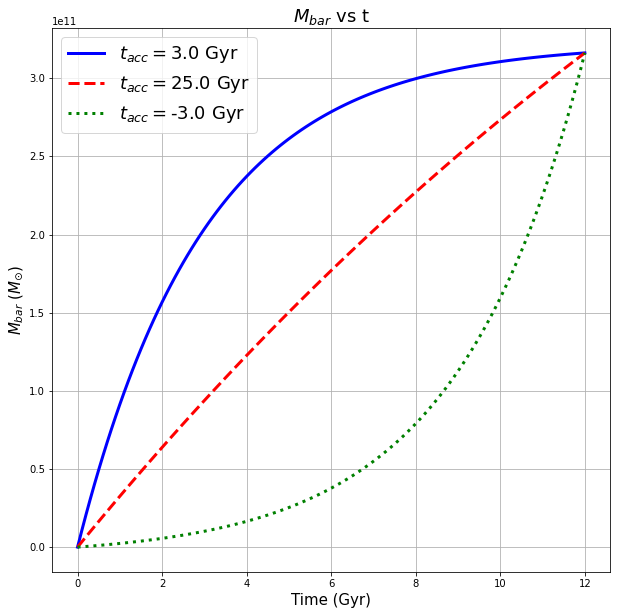

In [2]:
dt=0.1
M_times = np.arange(0,12.1,dt)

def C_def(M_bar, t_acc):
    if (t_acc==np.inf):
        return M_bar/12.
    elif (t_acc<0):
        return M_bar/(abs(t_acc)*(np.exp(12./abs(t_acc))-1))
    else:
        return M_bar/(t_acc*(1-np.exp(-12./t_acc)))

def M_def(M_bar, t_acc, t=M_times, dt=dt):
    C = C_def(M_bar, t_acc)
    if (t_acc==np.inf):
        return C*t
    elif (t_acc<0):
        return C*abs(t_acc)*(np.exp(t/abs(t_acc))-1)
    else:
        return C*t_acc*(1-np.exp(-t/t_acc))

t_acc = np.array([3.,25.,-3.]) #GYr
colors = ['b', 'r', 'g']
styles = ['solid', 'dashed', 'dotted']

M_bar_t0 = 10**11.5
M_bar_array = np.zeros((len(t_acc),len(M_times)))
for i, t_accr in enumerate(t_acc):
    M_bar_array[i] = M_def(M_bar_t0, t_accr)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
for i, t_accr, col, sty in zip(range(3), t_acc, colors, styles):
    frame.plot(M_times, M_bar_array[i], label = r"$t_{acc} = $"+f"{t_accr} Gyr", color=col, linestyle=sty, lw=3)
frame.set_title(r"$M_{bar}$ vs t", fontsize = 18)
frame.set_xlabel(r"Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{bar}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
pd.DataFrame(M_bar_array.T, columns=['t_acc=3Gyr', 't_acc=10Gyr', 't_acc=25Gyr']).to_csv('data3/M_bar_vs_'+f'{np.log10(M_bar_t0)}'+'.csv')
fig.savefig('graphs4/M_bar vs time (t_acc variation).png')

### a) i) Find $v_{BTFR}$ from $M_{bar}$ (constant in time)

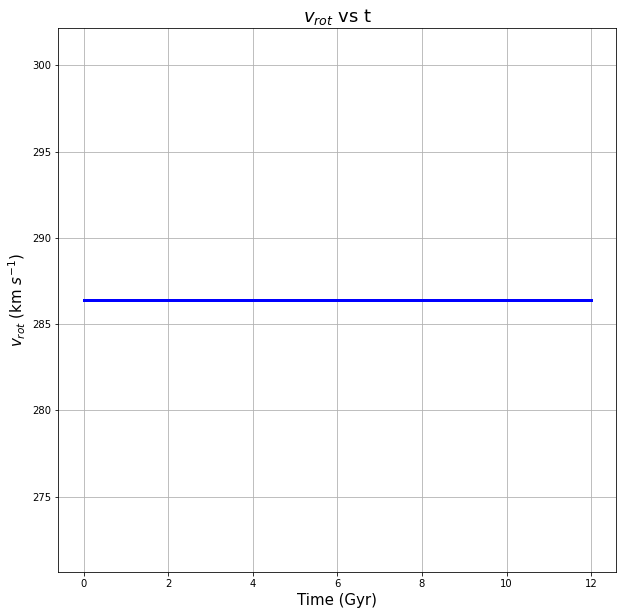

In [3]:
def v_btfr_def(M_bar, Ag=47):
    return (M_bar/Ag)**0.25

Ag = 47 #M_{\odot} km^{-4} s^{-4}
M_bar_allsame = np.full(M_bar_array[0].shape, M_bar_t0)
v_btfr_array = v_btfr_def(M_bar_allsame)
#print(v_rot_array)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times, v_btfr_array, color="blue", lw=3)
frame.set_title(r"$v_{rot}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$v_{rot}$ (km $s^{-1}$)", fontsize = 15)
#frame.legend(prop={'size': 18})
frame.grid()
show()
np.savetxt('data3/v_rot_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', v_btfr_array)
fig.savefig('graphs4/v_btfr vs time (t_acc variation).png')

### b) Determine $j_{max}$ from $\log(j_{max}(M_{bar})) = 0.73\log(M_{bar})-4.25$

In [4]:
def j_maxer(Mbar):
    return (Mbar**0.73)*10**(-4.25)

j_max = (M_bar_t0**0.73)*10**(-4.25)
print(j_max)

13963.68361055937


### c) Determine $j_{acc}(t)$ from $j_{max}(M_{bar})$

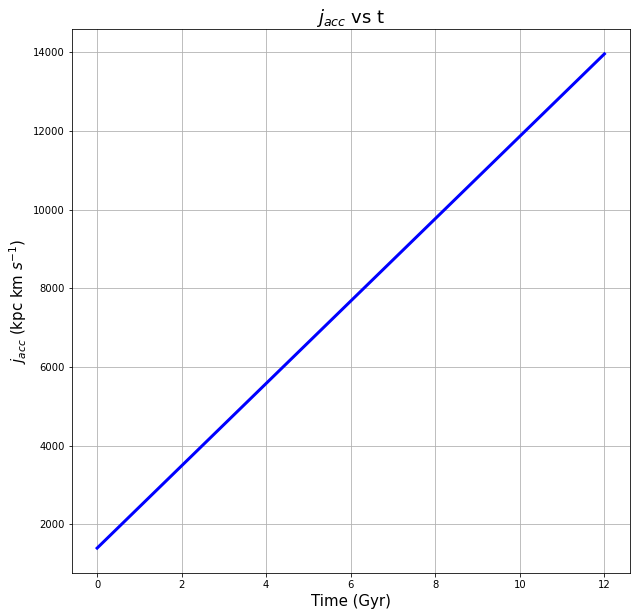

In [5]:
def j_acc_def(j_max, Mbar, t, t0=12, n=1, con=1):
    #r_acc_min = (10**(0.385*(np.log10(Mbar)-10)+0.281))/5
    j_min = j_max/10.
    return j_min+con*(j_max-j_min)*(t/t0)**n

j_acc_array = j_acc_def(j_max, M_bar_allsame, M_times)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times, j_acc_array, color="blue", lw=3)
frame.set_title(r"$j_{acc}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$j_{acc}$ (kpc km $s^{-1}$)", fontsize = 15)
#frame.legend(prop={'size': 18})
frame.grid()
show()
np.savetxt('data3/j_acc_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', j_acc_array)
fig.savefig('graphs4/j_acc vs time (t_acc variation).png')

### d) Determine $r_{BTFR}(t)$ from $r_{BTFR}(t) = \frac{j_{acc}(t)}{2 v_{BTFR}(t)}$

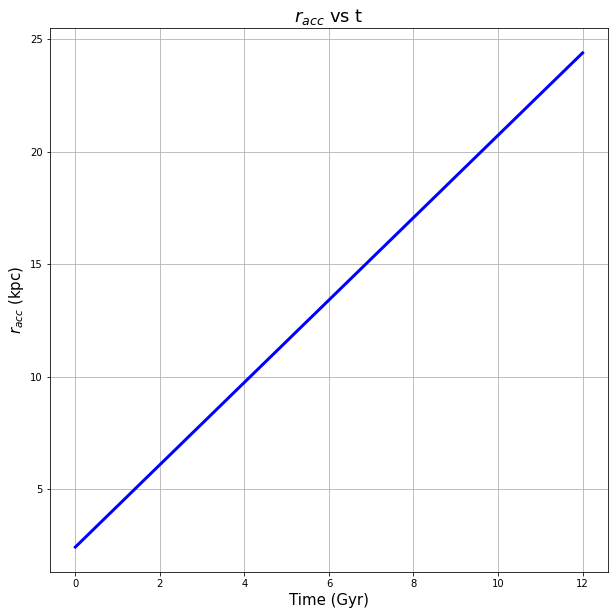

In [6]:
def r_btfr_def(M_bar, j_acc):
    return np.nan_to_num(j_acc/(2*v_btfr_def(M_bar)))

r_btfr_array = r_btfr_def(M_bar_allsame, j_acc_array)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times, r_btfr_array, color="blue", lw=3)
frame.set_title(r"$r_{acc}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$r_{acc}$ (kpc)", fontsize = 15)
#frame.legend(prop={'size': 18})
frame.grid()
show()
np.savetxt('data3/r_acc_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', r_btfr_array)
fig.savefig('graphs4/r_acc vs time (t_acc variation).png')

## 2) Solve $\frac{\mathrm{d} \Sigma_{gas}(t,R)}{\mathrm{d} t} = \frac{C}{2 \pi r_{acc}(t)^2} e^{-\frac{t}{t_{acc}}} e^{-\frac{R}{r_{acc}(t)}} - A(1-\Re) \Sigma_{gas}^N(t,R)$ given $r_{acc}(t)$ from (1)

In [7]:
N = 1.4 #below
A = 0.1625 # with N above used in K-S law
Rf = 0.3 #return factor
Ag = 47

def RungeKutta(x, y, dx, dydx):
    """
    Runge-Kutta method to solve differential equations.
    
    x = (initial) x values
    y = (initial) y values
    dx = step size
    dydx = differential equation
    """
    # Calculate slopes
    k1 = dx*dydx(x, y)
    k2 = dx*dydx(x+dx/2., y+k1/2.)
    k3 = dx*dydx(x+dx/2., y+k2/2.)
    k4 = dx*dydx(x+dx, y+k3)
    
    # Calculate new x and y
    y = y + (1./6.)*(k1+2*k2+2*k3+k4)
    x = x + dx
    
    return x, y

def Sigma_definer(r,t_acc,M_bar,n=1,con=1):
    """
    This fucntion defines the gas surface density 2D array, 
    where the columns are for varying radius, and the rows are for varying time.
    As input it takes:
    r = the radius 1D array, giving the max and min values of the radius of a galaxy
    r_acc = radial scale length of accretion
    t_acc = accretion timescale
    C = Gives value of the desired baryonic mass at a time t (usually t_0)
    """
    M_sigma = np.zeros(len(r)*(len(M_times)+1)).reshape(len(r),len(M_times)+1)
    C = C_def(M_bar, t_acc)
    jmax = (M_bar**0.73)*10**(-4.25)
    
    for i, r_value in enumerate(r):
        def dydx(t, S):
            r_acc = 1000*r_btfr_def(M_bar, j_acc_def(jmax, M_bar, t, n=n, con=con))
            #r_acc = 1000*np.nan_to_num(j_acc_def(j_max, t)/(2*((C*t_acc*(1-np.exp(-t/t_acc)))/Ag)**0.25))
            #if (r_acc == 0):
            #    r_acc = 100.
            return (C/(2*np.pi*(r_acc**2)))*np.exp(-t/t_acc)*np.exp(-r_value/r_acc)-A*(1-Rf)*(S**N)
        x0 = 0.
        y0 = 0.
        dx = 0.1
        x_end = 12
        
        #row = spint.solve_ivp(dydx, [x0, x_end], [y0], t_eval=M_times)
        
        row = np.zeros(len(M_times)+1)
        
        y = y0
        x = x0
        j=1
        while x <= x_end:
            x, y = RungeKutta(x, y, dx, dydx)
            #t_1[j] = np.round(x,1)
            #print(y)
            row[j] = y
            j+=1

        M_sigma[i,:] = row
    return M_sigma

#r_acc_array = np.nan_to_num(r_acc_array)*1000
#print(r_acc_array)
r = np.arange(0,1000*100.1,120)
M_sigma1 = Sigma_definer(r, t_acc[0], M_bar_t0)
np.savetxt('data3/M_sigma1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma1)
print(M_sigma1)

[[0.00000000e+00 2.51554187e+02 4.31649432e+02 ... 1.04903962e+01
  1.02438616e+01 1.00045910e+01]
 [0.00000000e+00 2.40089615e+02 4.13116742e+02 ... 1.04555108e+01
  1.02101019e+01 9.97191416e+00]
 [0.00000000e+00 2.29143971e+02 3.95365663e+02 ... 1.04206788e+01
  1.01763931e+01 9.93928565e+00]
 ...
 [0.00000000e+00 2.47800747e-15 3.03430860e-14 ... 6.56679009e-02
  6.62993714e-02 6.69120514e-02]
 [0.00000000e+00 2.36485252e-15 2.90381631e-14 ... 6.52330210e-02
  6.58624690e-02 6.64732538e-02]
 [0.00000000e+00 2.25686660e-15 2.77893975e-14 ... 6.48011070e-02
  6.54285318e-02 6.60374201e-02]]


In [8]:
M_times1 = np.arange(0,12.2,dt)
M_sigma2 = Sigma_definer(r, t_acc[1], M_bar_t0)
M_sigma3 = Sigma_definer(r, t_acc[2], M_bar_t0)
np.savetxt('data3/M_sigma2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma2)
np.savetxt('data3/M_sigma3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, M_sigma1[1], label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, M_sigma2[1], label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, M_sigma3[1], label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"$\Sigma_{gas}$ vs t at $r=120$pc", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$\Sigma_{gas}$ $(M_\odot\ pc^{-2})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
#fig.savefig('graphs4/Sigma_gas vs time (at r=120pc) with t_acc variation.png')

In [9]:
def find_nearest(array, value):
    """
    Finds nearest element in an array with wanted value
    
    Inputs:
    array(np.array): array to extract closest element to wanted value
    value(int): wanted value to find closest element to
    
    Returns:
    array[idx]: indexed array with index of closest value
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#def Slicer(array, r_val, t_val):
#    index_r = np.argwhere(r == find_nearest(r, r_val))[0][0]
#    index_t = np.argwhere(M_times1 == find_nearest(M_times1, t_val))[0][0]
    

index_r1 = np.argwhere(r == find_nearest(r, 25000.))[0][0]
index_r2 = np.argwhere(r == find_nearest(r, 50000.))[0][0]
index_r3 = np.argwhere(r == find_nearest(r, 75000.))[0][0]
index_r4 = np.argwhere(r == find_nearest(r, 100000.))[0][0]

#fig = figure(figsize=(10,10), facecolor='w')
#frame = fig.add_subplot(1,1,1)
#frame.plot(M_times1, M_sigma1[1], label=r"$r = 0.12$kpc", color="blue", lw=3)
#frame.plot(M_times1, M_sigma1[index_r1,:], label=r"$r = 25$kpc", color="red", lw=3)
#frame.plot(M_times1, M_sigma1[index_r2,:], label=r"$r = 50$kpc", linestyle="dashed", color="green", lw=3)
#frame.plot(M_times1, M_sigma1[index_r3,:], label=r"$r = 75$kpc", linestyle="dotted", color="black", lw=3)
#frame.plot(M_times1, M_sigma1[index_r4,:], label=r"$r = 100$kpc", linestyle="dashdot", color="violet", lw=3)
#frame.set_title(r"$\Sigma_{gas}$ vs t at $t_{acc} = 3$Gyr for different r", fontsize = 18)
#frame.set_xlabel("Time (Gyr)", fontsize = 15)
#frame.set_ylabel(r"$\Sigma_{gas}$ $(M_\odot\ pc^{-2})$", fontsize = 15)
#frame.legend(prop={'size': 18})
#frame.grid()
#show()
#fig.savefig('graphs4/Sigma_gas vs time at t_acc=3Gyr for 5 different r.png')

### $log(\dot{\Sigma}_{acc})$ vs r for different t and $t_{acc}$

In [10]:
def Sigma_acc_def(R, t, t_acc, M_bar):
    """
    Defines Sigma_acc rate (dotted), the accretion rate surface density, as a function of r and t
    
    Inputs:
    R(np.array): Radius array
    t(np.array): Time array
    t_acc(int): Accretion timescale value
    M_bar(float): Total baryonic mass value
    
    Returns:
    Sigma_acc_dot(np.array): 2D array of the accretion rate SD, with t in the x-axis and r in the y-axis
    """
    C = M_bar/(t_acc*(1-np.exp(-12./t_acc)))
    jmax = (M_bar**0.73)*10**(-4.25)
    r_acc = np.zeros(len(t))
    for j,ti in enumerate(t):
        r_acc[j] = 1000*np.nan_to_num(j_acc_def(jmax, M_bar, ti)/(2*((C*t_acc*(1-np.exp(-t[-1]/t_acc)))/Ag)**0.25))
        #if (r_acc[j] == 0):
        #    r_acc[j] = 100.
    Sigma_acc_dot = np.zeros((len(R),len(t)))
    for i,r_value in enumerate(R):
        Sigma_acc_dot[i,:] = ((C)/(2*np.pi*r_acc**2))*np.exp((-t)/(t_acc))*np.exp((-r_value)/(r_acc))
    return Sigma_acc_dot

M_sigma_acc_dot1 = Sigma_acc_def(r, M_times1, t_acc[0], M_bar_t0)
M_sigma_acc_dot2 = Sigma_acc_def(r, M_times1, t_acc[1], M_bar_t0)
M_sigma_acc_dot3 = Sigma_acc_def(r, M_times1, t_acc[2], M_bar_t0)
np.savetxt('data3/M_sigma_acc1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma_acc_dot1)
np.savetxt('data3/M_sigma_acc2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma_acc_dot2)
np.savetxt('data3/M_sigma_acc3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma_acc_dot3)
print(M_sigma_acc_dot1)

[[2.87654284e+03 2.40756175e+03 2.03480221e+03 ... 5.52978659e-01
  5.26857200e-01 5.02026135e-01]
 [2.73835268e+03 2.29978745e+03 1.94952865e+03 ... 5.50242418e-01
  5.24269717e-01 4.99578911e-01]
 [2.60680122e+03 2.19683765e+03 1.86782869e+03 ... 5.47519717e-01
  5.21694942e-01 4.97143616e-01]
 ...
 [4.67187432e-15 6.81266845e-14 6.91029167e-13 ... 8.91923374e-03
  8.76506114e-03 8.61055354e-03]
 [4.44743578e-15 6.50769991e-14 6.62069832e-13 ... 8.87509972e-03
  8.72201447e-03 8.56857972e-03]
 [4.23377934e-15 6.21638326e-14 6.34324112e-13 ... 8.83118408e-03
  8.67917922e-03 8.52681051e-03]]


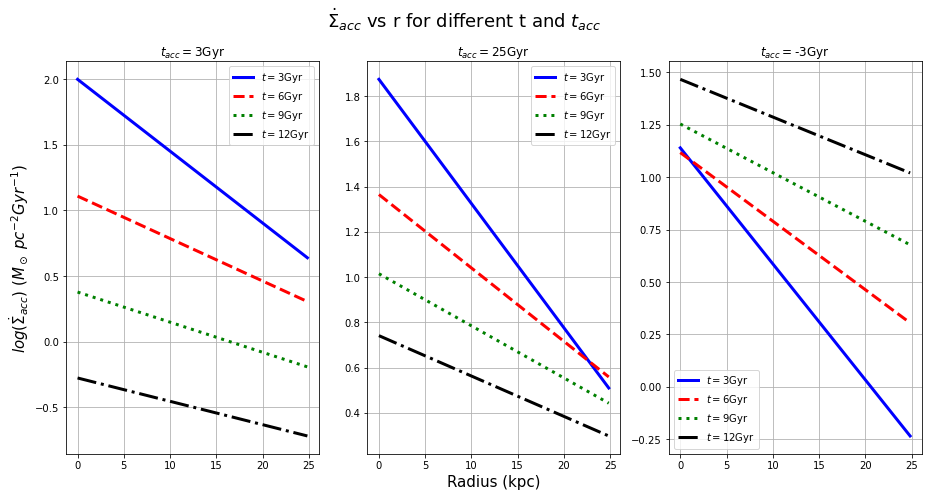

In [11]:
index_t1 = np.argwhere(M_times1 == 3.)[0][0]
index_t2 = np.argwhere(M_times1 == 6.)[0][0]
index_t3 = np.argwhere(M_times1 == 9.)[0][0]
index_t4 = np.argwhere(M_times1 == 12.)[0][0]
M_sigma_accs = np.array([M_sigma_acc_dot1, M_sigma_acc_dot2, M_sigma_acc_dot3])

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\dot{\Sigma}_{acc}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\dot{\Sigma}_{acc})$ $(M_\odot\ pc^{-2} Gyr^{-1})$", fontsize = 15)

for i, M, t_accr in zip(range(3), M_sigma_accs, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs4/dotSigma_acc vs r (t_acc variation).png')

### $log(\Sigma_{gas})$ vs r for different t and $t_{acc}$

warnings.filterwarnings('ignore')

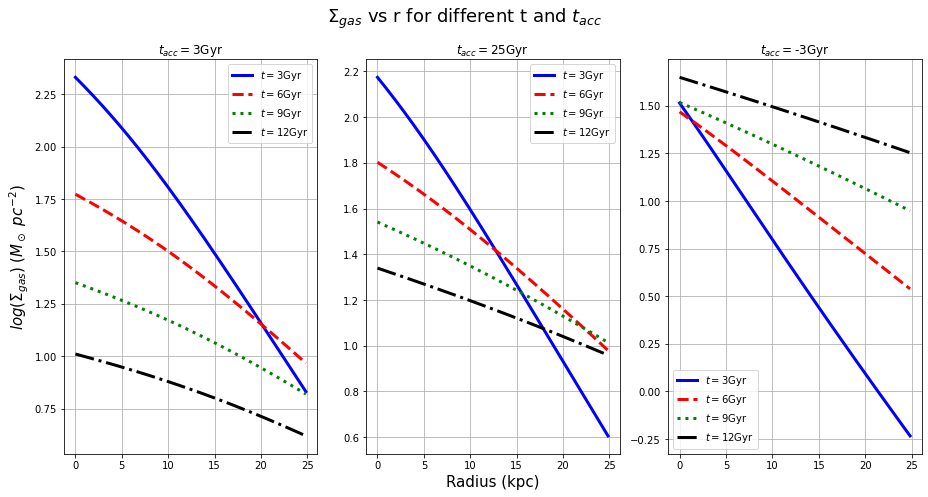

In [12]:
M_sigmas = np.array([M_sigma1, M_sigma2, M_sigma3])

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\Sigma_{gas}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\Sigma_{gas})$ $(M_\odot\ pc^{-2})$", fontsize = 15)

for i, M, t_accr in zip(range(3), M_sigmas, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs4/Sigma_gas vs r (t_acc variation).png')

#fig = figure(figsize=(10,10), facecolor='w')
#frame = fig.add_subplot(1,1,1)
#frame.plot(r, np.log10(M_sigma1[:,index_t1]), label=r"$t = 3$Gyr", color="blue", lw=3)
#frame.plot(r, np.log10(M_sigma1[:,index_t1]), label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
#frame.plot(r, np.log10(M_sigma1[:,index_t1]), label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
#frame.plot(r, np.log10(M_sigma1[:,index_t1]), label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
#frame.set_title(r"$\Sigma_{gas}$ vs r at $t_{acc} = 3$Gyr for different t", fontsize = 18)
#frame.set_xlabel("Radius (pc)", fontsize = 15)
#frame.set_ylabel(r"$\Sigma_{gas}$ $(M_\odot\ pc^{-2})$", fontsize = 15)
#frame.legend(prop={'size': 18})
#frame.grid()
#show()

### $log(\Sigma_{SFR})$ vs r for different t and $t_{acc}$

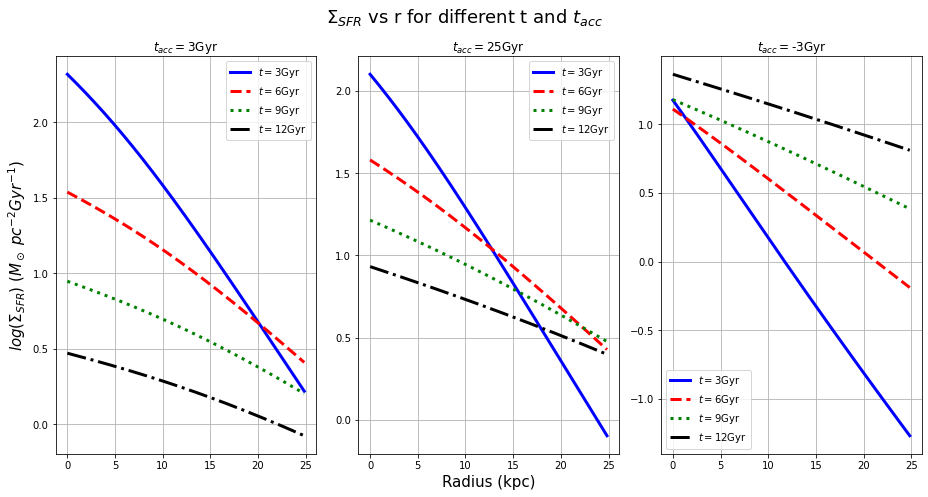

In [13]:
M_sfrs = A*(1-Rf)*M_sigmas**N
np.savetxt('data3/M_sfr1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sfrs[0])
np.savetxt('data3/M_sfr2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sfrs[1])
np.savetxt('data3/M_sfr3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sfrs[2])
#index_list_t = np.array([index_t1, index_t2, index_t3, index_t4])
#M_stars = Tsummer(M_sfrs, index_list_t)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\Sigma_{SFR}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\Sigma_{SFR})$ $(M_\odot\ pc^{-2} Gyr^{-1})$", fontsize = 15)

for i, M, t_accr in zip(range(3), M_sfrs, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs4/Sigma_sfr vs r (t_acc variation).png')

### $log(\Sigma_{\star})$ vs r for different t and $t_{acc}$

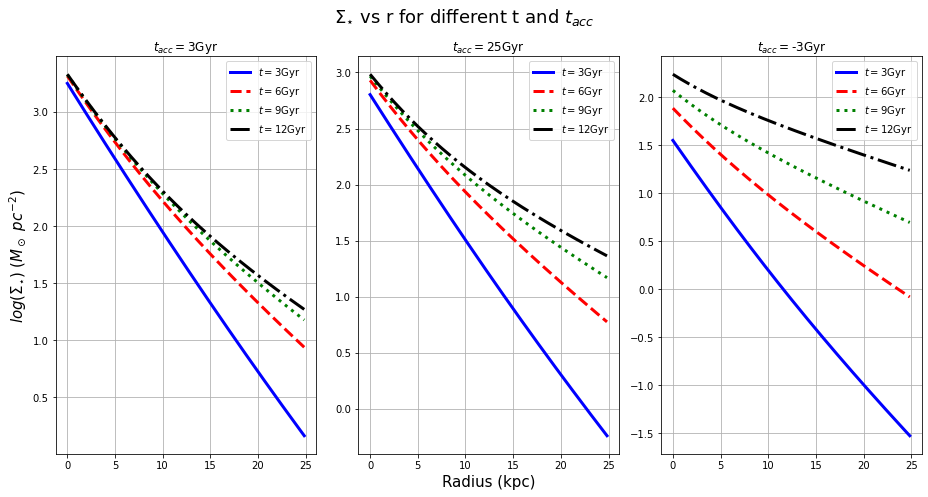

In [14]:
def Tsummer(arrays, indexs, axis=1, dt=dt):
    summed_arrays = np.zeros((3,4))
    for i,array in enumerate(arrays):
        summed_arrays[i] = dt*np.sum(array[:,:indexs], axis=axis)
    return summed_arrays

#index_list_t = np.array([index_t1, index_t2, index_t3, index_t4])
#M_stars = Tsummer(M_sfrs, index_list_t)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\Sigma_{\star}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\Sigma_{\star})$ $(M_\odot\ pc^{-2})$", fontsize = 15)

for i, M_sfr, t_accr in zip(range(3), M_sfrs, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(dt*np.sum(M_sfr[:,:index_t1], axis=1))[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(dt*np.sum(M_sfr[:,:index_t2], axis=1))[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(dt*np.sum(M_sfr[:,:index_t3], axis=1))[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(dt*np.sum(M_sfr[:,:index_t4], axis=1))[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs4/Sigma_star vs r (t_acc variation).png')

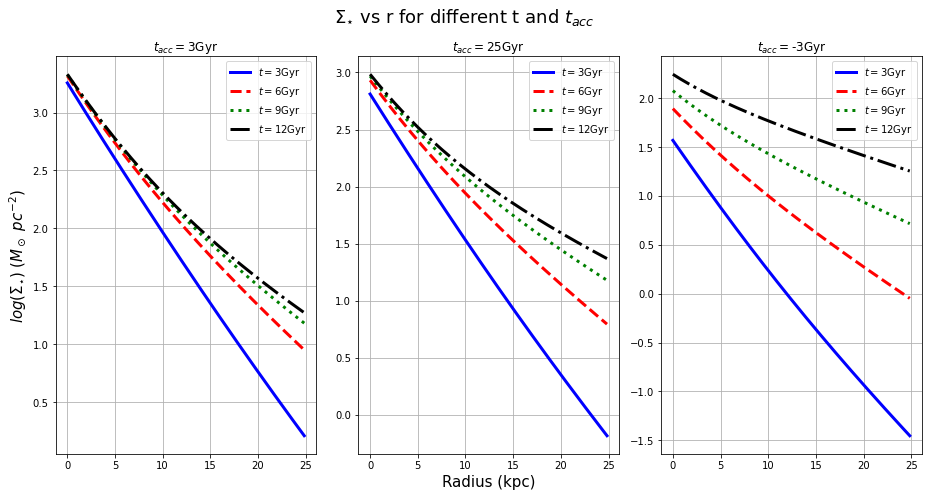

In [15]:
M_star1 = dt*np.cumsum(M_sfrs[0], axis=1)
M_star2 = dt*np.cumsum(M_sfrs[1], axis=1)
M_star3 = dt*np.cumsum(M_sfrs[2], axis=1)
M_stars = np.array([M_star1, M_star2, M_star3])
np.savetxt('data3/M_star1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_star1)
np.savetxt('data3/M_star2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_star2)
np.savetxt('data3/M_star3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_star3)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\Sigma_{\star}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\Sigma_{\star})$ $(M_\odot\ pc^{-2})$", fontsize = 15)

for i, M, t_accr in zip(range(3), M_stars, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()

### $log(\Sigma_{bar})$ vs r for different t and $t_{acc}$

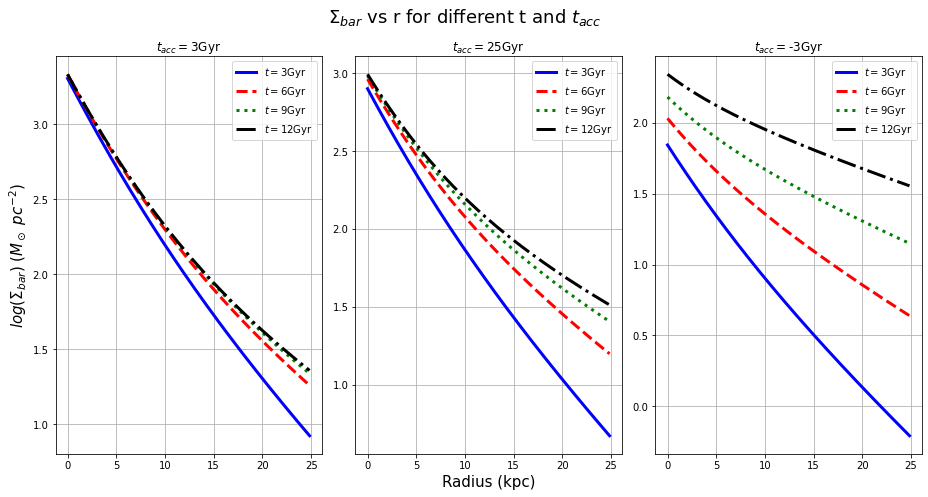

In [16]:
M_bar1 = np.array([np.sum(x) for x in zip(M_sigma1.ravel(), M_star1.ravel())]).reshape(M_sigma1.shape)
M_bar2 = np.array([np.sum(x) for x in zip(M_sigma2.ravel(), M_star2.ravel())]).reshape(M_sigma2.shape)
M_bar3 = np.array([np.sum(x) for x in zip(M_sigma3.ravel(), M_star3.ravel())]).reshape(M_sigma3.shape)
M_bars = np.array([M_bar1, M_bar2, M_bar3])
#print(M_bar1)
np.savetxt('data3/M_bar1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_bar1)
np.savetxt('data3/M_bar2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_bar2)
np.savetxt('data3/M_bar3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_bar3)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\Sigma_{bar}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\Sigma_{bar})$ $(M_\odot\ pc^{-2})$", fontsize = 15)

for i, M, t_accr in zip(range(3), M_bars, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs4/Sigma_bar vs r (t_acc variation).png')

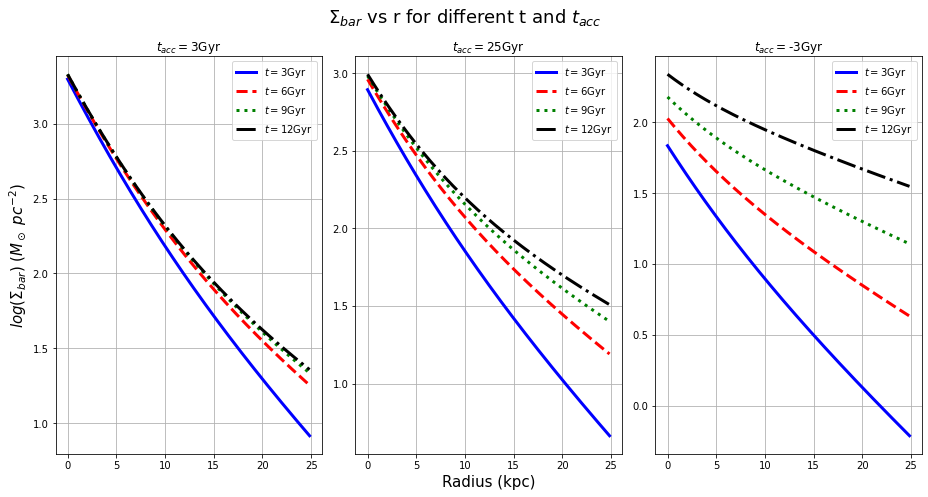

In [17]:
# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\Sigma_{bar}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\Sigma_{bar})$ $(M_\odot\ pc^{-2})$", fontsize = 15)

for i, M_sfr, M_sigma, t_accr in zip(range(3), M_sfrs, M_sigmas, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10([np.sum(x) for x in zip(M_sigma[:,index_t1], dt*np.sum(M_sfr[:,:index_t1], axis=1))])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10([np.sum(x) for x in zip(M_sigma[:,index_t2], dt*np.sum(M_sfr[:,:index_t2], axis=1))])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10([np.sum(x) for x in zip(M_sigma[:,index_t3], dt*np.sum(M_sfr[:,:index_t3], axis=1))])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10([np.sum(x) for x in zip(M_sigma[:,index_t4], dt*np.sum(M_sfr[:,:index_t4], axis=1))])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()

warnings.filterwarnings('default')

## $f_{gas}$ vs r

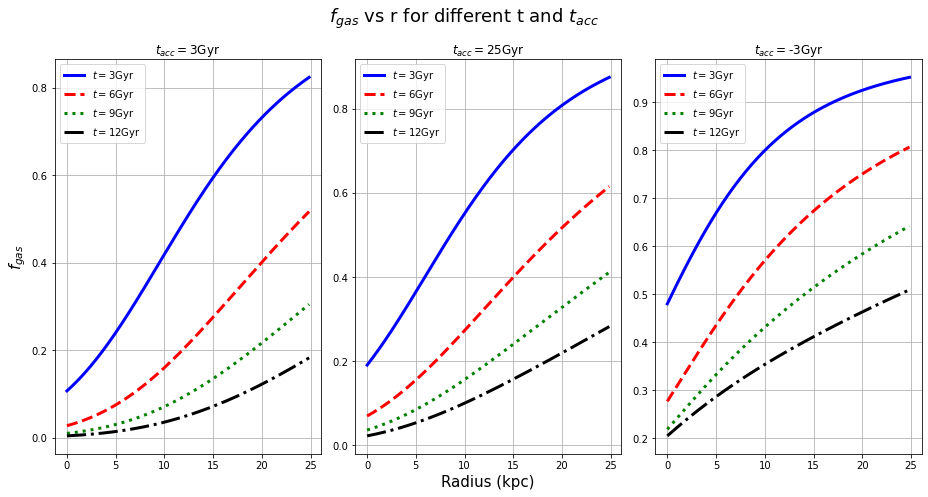

In [18]:
# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$f_{gas}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$f_{gas}$", fontsize = 15)

for i, M_sfr, M_sigma, t_accr in zip(range(3), M_sfrs, M_sigmas, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.divide(M_sigma[:,index_t1], [np.sum(x) for x in zip(M_sigma[:,index_t1], dt*np.sum(M_sfr[:,:index_t1], axis=1))])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.divide(M_sigma[:,index_t2], [np.sum(x) for x in zip(M_sigma[:,index_t2], dt*np.sum(M_sfr[:,:index_t2], axis=1))])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.divide(M_sigma[:,index_t3], [np.sum(x) for x in zip(M_sigma[:,index_t3], dt*np.sum(M_sfr[:,:index_t3], axis=1))])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.divide(M_sigma[:,index_t4], [np.sum(x) for x in zip(M_sigma[:,index_t4], dt*np.sum(M_sfr[:,:index_t4], axis=1))])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs4/f_gas vs r (t_acc variation).png')

/var/lib/condor/execute/dir_102800/ipykernel_102880/2859380956.py:1: RuntimeWarning: invalid value encountered in true_divide
  f_gas1 = np.divide(M_sigma1, M_bar1)
/var/lib/condor/execute/dir_102800/ipykernel_102880/2859380956.py:2: RuntimeWarning: invalid value encountered in true_divide
  f_gas2 = np.divide(M_sigma2, M_bar2)
/var/lib/condor/execute/dir_102800/ipykernel_102880/2859380956.py:3: RuntimeWarning: invalid value encountered in true_divide
  f_gas3 = np.divide(M_sigma3, M_bar3)


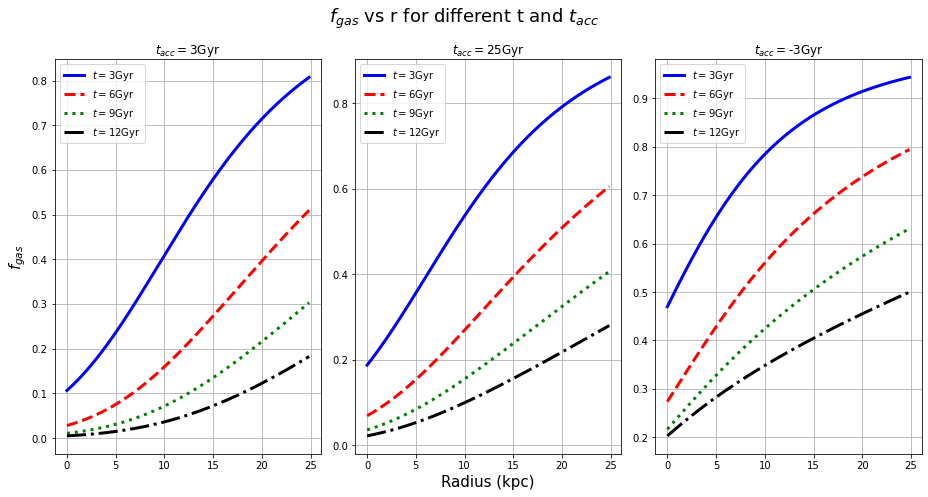

In [19]:
f_gas1 = np.divide(M_sigma1, M_bar1)
f_gas2 = np.divide(M_sigma2, M_bar2)
f_gas3 = np.divide(M_sigma3, M_bar3)
f_gass = np.array([f_gas1, f_gas2, f_gas3])
np.savetxt('data3/f_gas1_'+f'{np.log10(M_bar_t0)}'+'.txt', f_gas1)
np.savetxt('data3/f_gas2_'+f'{np.log10(M_bar_t0)}'+'.txt', f_gas2)
np.savetxt('data3/f_gas3_'+f'{np.log10(M_bar_t0)}'+'.txt', f_gas3)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$f_{gas}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$f_{gas}$", fontsize = 15)

for i, f_gas, t_accr in zip(range(3), f_gass, t_acc):
    axes[i].plot(r[:index_r1]/1000, f_gas[:,index_t1][:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, f_gas[:,index_t2][:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, f_gas[:,index_t3][:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, f_gas[:,index_t4][:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()

## SFE vs r

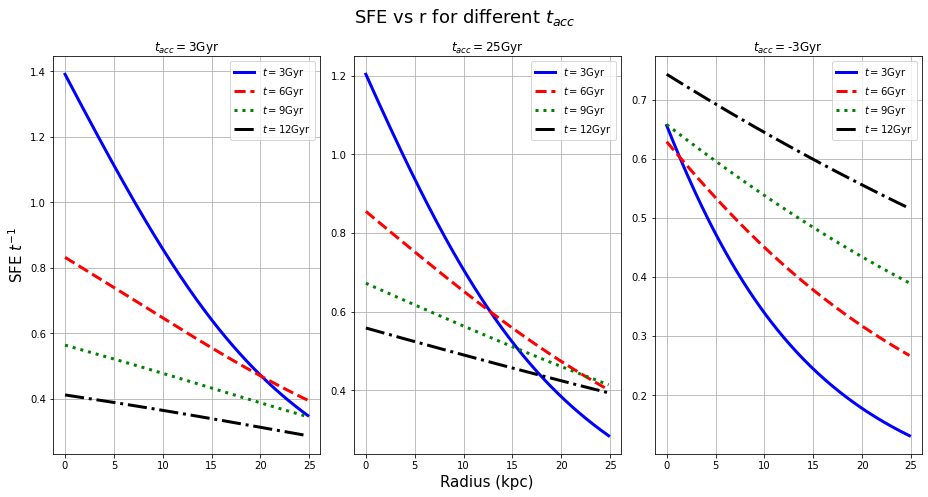

In [20]:
# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"SFE vs r for different $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"SFE $t^{-1}$", fontsize = 15)

for i, M_sigma, t_accr in zip(range(3), M_sigmas, t_acc):
    axes[i].plot(r[:index_r1]/1000, (A*M_sigma[:,index_t1]**(N-1))[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, (A*M_sigma[:,index_t2]**(N-1))[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, (A*M_sigma[:,index_t3]**(N-1))[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, (A*M_sigma[:,index_t4]**(N-1))[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs4/SFE vs r (t_acc variation).png')

## $M_{gas}$ vs t

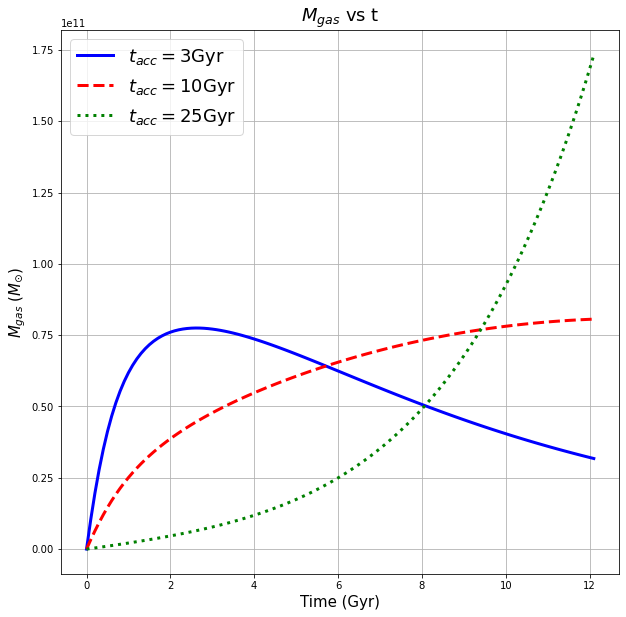

In [21]:
dr = 120
integral_r = r.reshape(835,1)
#Mass_gas_summed1 = 2*np.pi*dr*np.sum(integral_r*M_sigma1, axis=0)
#Mass_gas_summed2 = 2*np.pi*dr*np.sum(integral_r*M_sigma2, axis=0)
#Mass_gas_summed3 = 2*np.pi*dr*np.sum(integral_r*M_sigma3, axis=0)
Mass_gas_summed1 = 2*np.pi*spint.simpson(integral_r*M_sigma1, dx=dr, axis=0)
Mass_gas_summed2 = 2*np.pi*spint.simpson(integral_r*M_sigma2, dx=dr, axis=0)
Mass_gas_summed3 = 2*np.pi*spint.simpson(integral_r*M_sigma3, dx=dr, axis=0)
np.savetxt('data3/Mass_gas1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_gas_summed1)
np.savetxt('data3/Mass_gas2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_gas_summed2)
np.savetxt('data3/Mass_gas3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_gas_summed3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, Mass_gas_summed1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, Mass_gas_summed2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, Mass_gas_summed3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"$M_{gas}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{gas}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/M_gas vs time.png')

## $M_{\star}$ vs t

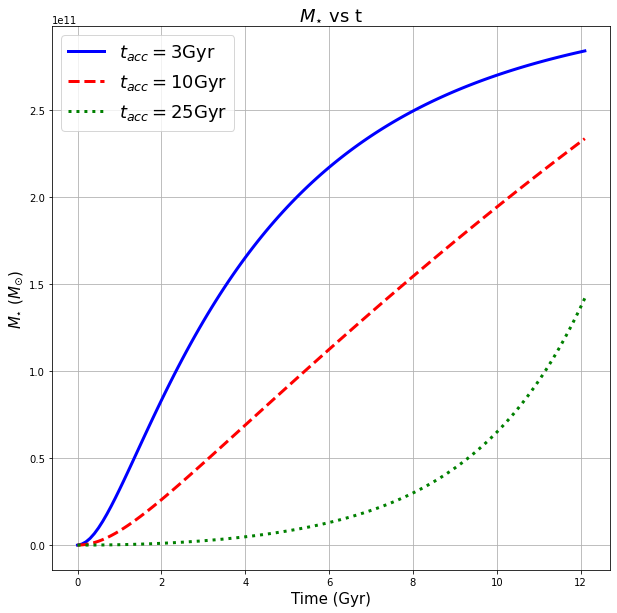

In [22]:
#Mass_time_star_1 = []
#Mass_time_star_2 = []
#Mass_time_star_3 = []
Mass_sfr_summed1 = 2*np.pi*spint.simpson(integral_r*M_sfrs[0], dx=dr, axis=0)#dr*np.sum(integral_r*M_sfrs[0], axis=0)
Mass_sfr_summed2 = 2*np.pi*spint.simpson(integral_r*M_sfrs[1], dx=dr, axis=0)#dr*np.sum(integral_r*M_sfrs[1], axis=0)
Mass_sfr_summed3 = 2*np.pi*spint.simpson(integral_r*M_sfrs[2], dx=dr, axis=0)#dr*np.sum(integral_r*M_sfrs[2], axis=0)

dt = 0.1
#for i in range(len(M_times1)):
#    Mass_time_star_1.append(dt*np.sum(Mass_sfr_summed1[:i]))
#    Mass_time_star_2.append(dt*np.sum(Mass_sfr_summed2[:i]))
#    Mass_time_star_3.append(dt*np.sum(Mass_sfr_summed3[:i]))

Mass_time_star_1 = dt*np.cumsum(Mass_sfr_summed1)
Mass_time_star_2 = dt*np.cumsum(Mass_sfr_summed2)
Mass_time_star_3 = dt*np.cumsum(Mass_sfr_summed3)

np.savetxt('data3/Mass_star1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_star_1)
np.savetxt('data3/Mass_star2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_star_2)
np.savetxt('data3/Mass_star3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_star_3)
    
#for i in range(len(M_times1)):
#    Mass_time_star_1.append(spint.simpson(Mass_sfr_summed1[:i], dx=dt))
#    Mass_time_star_2.append(spint.simpson(Mass_sfr_summed2[:i], dx=dt))
#    Mass_time_star_3.append(spint.simpson(Mass_sfr_summed3[:i], dx=dt))

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, Mass_time_star_1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, Mass_time_star_2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, Mass_time_star_3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"$M_{\star}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{\star}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/M_star vs time.png')

## $M_{bar}$ vs t

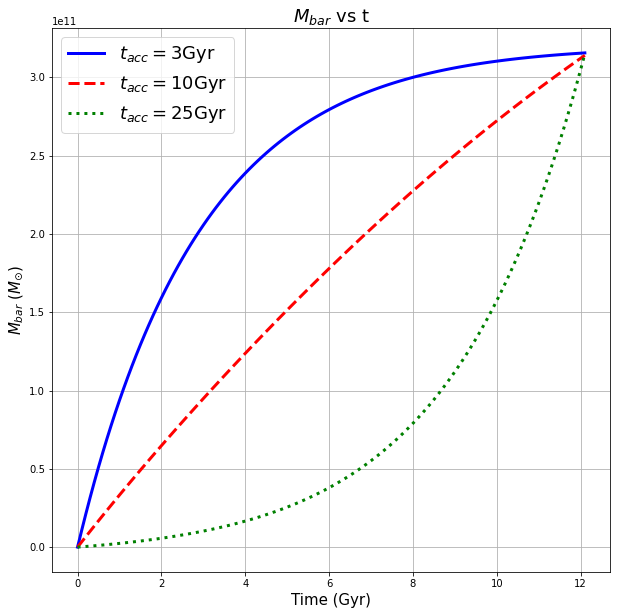

In [23]:
Mass_time_bar_1 = [np.sum(x) for x in zip(Mass_time_star_1, Mass_gas_summed1)]
Mass_time_bar_2 = [np.sum(x) for x in zip(Mass_time_star_2, Mass_gas_summed2)]
Mass_time_bar_3 = [np.sum(x) for x in zip(Mass_time_star_3, Mass_gas_summed3)]

np.savetxt('data3/Mass_bar1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_bar_1)
np.savetxt('data3/Mass_bar2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_bar_2)
np.savetxt('data3/Mass_bar3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_bar_3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, Mass_time_bar_1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, Mass_time_bar_2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, Mass_time_bar_3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"$M_{bar}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{bar}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/M_bar vs time.png')

#  Global $f_{gas}$ vs t

/var/lib/condor/execute/dir_102800/ipykernel_102880/375277253.py:1: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas1 = np.divide(Mass_gas_summed1, Mass_time_bar_1)
/var/lib/condor/execute/dir_102800/ipykernel_102880/375277253.py:2: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas2 = np.divide(Mass_gas_summed2, Mass_time_bar_2)
/var/lib/condor/execute/dir_102800/ipykernel_102880/375277253.py:3: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas3 = np.divide(Mass_gas_summed3, Mass_time_bar_3)


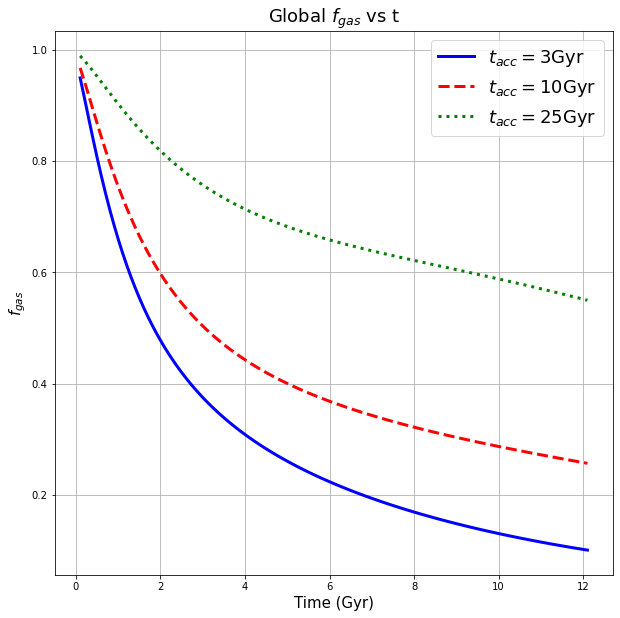

In [24]:
f_global_gas1 = np.divide(Mass_gas_summed1, Mass_time_bar_1)
f_global_gas2 = np.divide(Mass_gas_summed2, Mass_time_bar_2)
f_global_gas3 = np.divide(Mass_gas_summed3, Mass_time_bar_3)

np.savetxt('data3/f_gas1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', f_global_gas1)
np.savetxt('data3/f_gas2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', f_global_gas2)
np.savetxt('data3/f_gas3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', f_global_gas3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, f_global_gas1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, f_global_gas2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, f_global_gas3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"Global $f_{gas}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$f_{gas}$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/Global f_gas vs time.png')

# Specific Angular Momentum $j_{bar}$

/var/lib/condor/execute/dir_185487/ipykernel_185591/397120758.py:29: RuntimeWarning: invalid value encountered in true_divide
  j_bar1 = np.divide(Nominator1, Mass_time_bar_1[:-1])
/var/lib/condor/execute/dir_185487/ipykernel_185591/397120758.py:30: RuntimeWarning: invalid value encountered in true_divide
  j_bar2 = np.divide(Nominator2, Mass_time_bar_2[:-1])
/var/lib/condor/execute/dir_185487/ipykernel_185591/397120758.py:31: RuntimeWarning: invalid value encountered in true_divide
  j_bar3 = np.divide(Nominator3, Mass_time_bar_3[:-1])


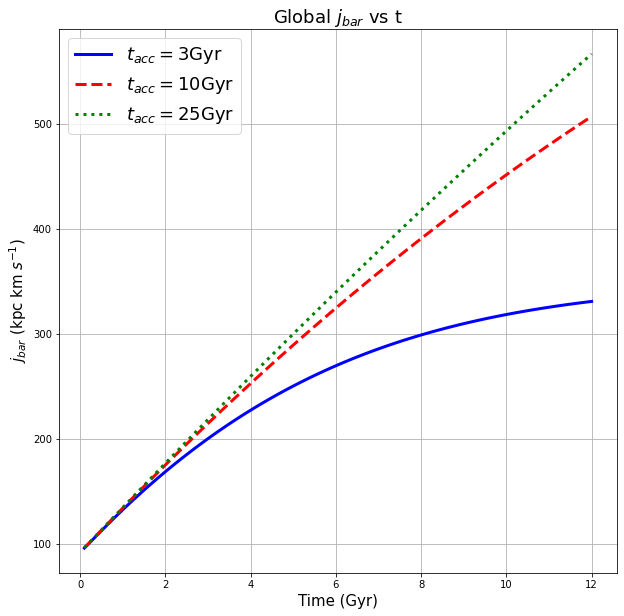

In [27]:
Nominator_gas1 = 2*np.pi*spint.simpson(integral_r**2*M_sigma1, dx=dr, axis=0)#2*np.pi*dr*np.sum(integral_r**2*M_sigma1, axis=0)
Nominator_gas2 = 2*np.pi*spint.simpson(integral_r**2*M_sigma2, dx=dr, axis=0)#2*np.pi*dr*np.sum(integral_r**2*M_sigma2, axis=0)
Nominator_gas3 = 2*np.pi*spint.simpson(integral_r**2*M_sigma3, dx=dr, axis=0)#2*np.pi*dr*np.sum(integral_r**2*M_sigma3, axis=0)

#Nominator_star1 = []
#Nominator_star2 = []
#Nominator_star3 = []
sfr_r_squared1 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs[0], dx=dr, axis=0)#2*np.pi*dr*np.sum(integral_r**2*M_sfrs[0], axis=0)
sfr_r_squared2 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs[1], dx=dr, axis=0)#2*np.pi*dr*np.sum(integral_r**2*M_sfrs[1], axis=0)
sfr_r_squared3 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs[2], dx=dr, axis=0)#2*np.pi*dr*np.sum(integral_r**2*M_sfrs[2], axis=0)

#for i in range(len(M_times1)):
#    Nominator_star1.append(dt*np.sum(sfr_r_squared1[:i]))
#    Nominator_star2.append(dt*np.sum(sfr_r_squared2[:i]))
#    Nominator_star3.append(dt*np.sum(sfr_r_squared3[:i]))

Nominator_star1 = dt*np.cumsum(sfr_r_squared1)
Nominator_star2 = dt*np.cumsum(sfr_r_squared2)
Nominator_star3 = dt*np.cumsum(sfr_r_squared3)

Nominator_bar1 = [np.sum(x) for x in zip(Nominator_star1, Nominator_gas1)]
Nominator_bar2 = [np.sum(x) for x in zip(Nominator_star2, Nominator_gas2)]
Nominator_bar3 = [np.sum(x) for x in zip(Nominator_star3, Nominator_gas3)]

Nominator1 = v_btfr_array[0]*Nominator_bar1[:-1]
Nominator2 = v_btfr_array[1]*Nominator_bar2[:-1]
Nominator3 = v_btfr_array[2]*Nominator_bar3[:-1]

j_bar1 = np.divide(Nominator1, Mass_time_bar_1[:-1])
j_bar2 = np.divide(Nominator2, Mass_time_bar_2[:-1])
j_bar3 = np.divide(Nominator3, Mass_time_bar_3[:-1])

np.savetxt('data3/j_bar1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', j_bar1)
np.savetxt('data3/j_bar2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', j_bar2)
np.savetxt('data3/j_bar3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', j_bar3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times, j_bar1/1000, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times, j_bar2/1000, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times, j_bar3/1000, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"Global $j_{bar}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$j_{bar}$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/Global j_bar vs time.png')

## Preliminary Plot (3 $t_{acc}$, 4 $M_{bar}$)

In [28]:
def Half_definer(Mbar, t_acc_arr, res=120, Rmax=100.1, at_t0=True, ns=0.75, cons=1.5):
    """Defines the fraction of gas and baryonic specific angular momentum arrays, with Mbar and t_acc as input"""
    
    r = np.arange(0,1000*Rmax,res)
    dr = res
    jmaxx = (Mbar**0.73)*10**(-4.25)
    
    #M_sigma_r = np.zeros(10,len(r))
    #M_sfr_r = np.zeros(10,len(r))
    #for i,r_acc in enumerate(r_acc_array):
    #    M_sigma_r[i] = Sigma_definer(r,r_acc,t_acc,C)
    #    M_sfr_r[i] = A*(1-Rf)*M_sigma_r[i]**N
    
    M_sigma_t1 = Sigma_definer(r,t_acc_arr[0],Mbar,n=ns,con=cons)
    M_sigma_t2 = Sigma_definer(r,t_acc_arr[1],Mbar,n=ns,con=cons)
    M_sigma_t3 = Sigma_definer(r,t_acc_arr[2],Mbar,n=ns,con=cons)
    
    M_sfr_t1 = A*(1-Rf)*M_sigma_t1**N
    M_sfr_t2 = A*(1-Rf)*M_sigma_t2**N
    M_sfr_t3 = A*(1-Rf)*M_sigma_t3**N
    
    r = r.reshape(len(r),1)
    #Mass_gas_summed_r = np.zeros(10,len(r))
    #for i in range(len(r_acc_array)):
    #    Mass_gas_summed_r[i] = 2*np.pi*dr*np.sum(r*M_sigma_r[i], axis=0)
    
    Mass_gas_summed_t1 = 2*np.pi*spint.simpson(r*M_sigma_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r*M_sigma_t1, axis=0)
    Mass_gas_summed_t2 = 2*np.pi*spint.simpson(r*M_sigma_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])#2*np.pi*spint.simpson(r*M_sigma_t2[:,-1], dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t2, axis=0)
    Mass_gas_summed_t3 = 2*np.pi*spint.simpson(r*M_sigma_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])#2*np.pi*spint.simpson(r*M_sigma_t3[:,-1], dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t3, axis=0)
    
    #Mass_time_star_t1 = []
    #Mass_time_star_t2 = []
    #Mass_time_star_t3 = []
    Mass_sfr_summed_t1 = 2*np.pi*spint.simpson(r*M_sfr_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t1, axis=0)
    Mass_sfr_summed_t2 = 2*np.pi*spint.simpson(r*M_sfr_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t2, axis=0)
    Mass_sfr_summed_t3 = 2*np.pi*spint.simpson(r*M_sfr_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t3, axis=0)
    
    #for i in range(len(M_times1)):
    #    Mass_time_star_t1.append(dt*np.sum(Mass_sfr_summed_t1[:i]))
    #    Mass_time_star_t2.append(dt*np.sum(Mass_sfr_summed_t2[:i]))
    #    Mass_time_star_t3.append(dt*np.sum(Mass_sfr_summed_t3[:i]))
    
    Mass_time_star_t1 = dt*np.cumsum(Mass_sfr_summed_t1)
    Mass_time_star_t2 = dt*np.cumsum(Mass_sfr_summed_t2)
    Mass_time_star_t3 = dt*np.cumsum(Mass_sfr_summed_t3)

    Mass_time_bar_t1 = [np.sum(x) for x in zip(Mass_time_star_t1, Mass_gas_summed_t1)]#Mass_gas_summed_t1+Mass_time_star_t1 #
    Mass_time_bar_t2 = [np.sum(x) for x in zip(Mass_time_star_t2, Mass_gas_summed_t2)]#Mass_gas_summed_t2+Mass_time_star_t2 #
    Mass_time_bar_t3 = [np.sum(x) for x in zip(Mass_time_star_t3, Mass_gas_summed_t3)]#Mass_gas_summed_t3+Mass_time_star_t3 #
    
    f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
    f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
    f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
    
    M_bar_array = np.zeros((len(t_acc_arr),len(M_times1)))
    for i, t_accr in enumerate(t_acc_arr):
        M_bar_array[i] = M_def(Mbar, t_accr, t=M_times1)
    
    j_acc_array = np.zeros((len(t_acc_arr),len(M_times1)))
    for i in range(len(t_acc_arr)):
        j_acc_array[i] = j_acc_def(j_max, M_times1)
     
    v_rot_array = v_rot_def(r_btfr_def(M_bar_array, j_acc_array), j_max, M_times1, Mbar)
    #v_rot_t1 = (np.array(Mass_time_bar_t1)/Ag)**0.25
    #v_rot_t2 = (np.array(Mass_time_bar_t2)/Ag)**0.25
    #v_rot_t3 = (np.array(Mass_time_bar_t3)/Ag)**0.25
    
    Nominator_gas_t1 = 2*np.pi*spint.simpson(r**2*M_sigma_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t1, axis=0)
    Nominator_gas_t2 = 2*np.pi*spint.simpson(r**2*M_sigma_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t2, axis=0)
    Nominator_gas_t3 = 2*np.pi*spint.simpson(r**2*M_sigma_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t3, axis=0)

    #Nominator_star_t1 = []
    #Nominator_star_t2 = []
    #Nominator_star_t3 = []
    sfr_r_squared_t1 = 2*np.pi*spint.simpson(r**2*M_sfr_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t1, axis=0)
    sfr_r_squared_t2 = 2*np.pi*spint.simpson(r**2*M_sfr_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t2, axis=0)
    sfr_r_squared_t3 = 2*np.pi*spint.simpson(r**2*M_sfr_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t3, axis=0)

    #for i in range(len(M_times1)):
    #    Nominator_star_t1.append(dt*np.sum(sfr_r_squared_t1[:i]))
    #    Nominator_star_t2.append(dt*np.sum(sfr_r_squared_t2[:i]))
    #    Nominator_star_t3.append(dt*np.sum(sfr_r_squared_t3[:i]))
    
    Nominator_star_t1 = dt*np.cumsum(sfr_r_squared_t1)
    Nominator_star_t2 = dt*np.cumsum(sfr_r_squared_t2)
    Nominator_star_t3 = dt*np.cumsum(sfr_r_squared_t3)

    Nominator_bar_t1 = [np.sum(x) for x in zip(Nominator_star_t1, Nominator_gas_t1)]#Nominator_gas_t1+Nominator_star_t1#
    Nominator_bar_t2 = [np.sum(x) for x in zip(Nominator_star_t2, Nominator_gas_t2)]#Nominator_gas_t2+Nominator_star_t2#
    Nominator_bar_t3 = [np.sum(x) for x in zip(Nominator_star_t3, Nominator_gas_t3)]#Nominator_gas_t3+Nominator_star_t3#
 
    Nominator_t1 = v_rot_array[0]*Nominator_bar_t1##v_rot_t1*Nominator_bar_t1
    Nominator_t2 = v_rot_array[1]*Nominator_bar_t2##v_rot_t2*Nominator_bar_t2
    Nominator_t3 = v_rot_array[2]*Nominator_bar_t3##v_rot_t3*Nominator_bar_t3

    j_bar_t1 = np.divide(Nominator_t1,Mass_time_bar_t1)#Nominator_t1/M_bar_array[0]#
    j_bar_t2 = np.divide(Nominator_t2,Mass_time_bar_t2)#Nominator_t2/M_bar_array[1]#
    j_bar_t3 = np.divide(Nominator_t3,Mass_time_bar_t3)#Nominator_t3/M_bar_array[2]#
    
    if (at_t0==True):
        f_gas_array = np.array([f_global_gas_t1[-1], f_global_gas_t2[-1], f_global_gas_t3[-1]])
        j_bar_array = np.array([j_bar_t1[-1]/1000, j_bar_t2[-1]/1000, j_bar_t3[-1]/1000])
    else:
        f_gas_array = np.array([f_global_gas_t1, f_global_gas_t2, f_global_gas_t3])
        j_bar_array = np.array([j_bar_t1/1000, j_bar_t2/1000, j_bar_t3/1000])
    
    return f_gas_array, j_bar_array

/var/lib/condor/execute/dir_2565397/ipykernel_2811050/1945494744.py:51: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_2565397/ipykernel_2811050/1945494744.py:52: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_2565397/ipykernel_2811050/1945494744.py:53: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_2565397/ipykernel_2811050/1945494744.py:96: RuntimeWarning: invalid value encountered in true_divide
  j_bar_t1 = np.divide(Nominator_t1,Mass_time_bar_t1)#Nominator_t1/M_bar_array[0]#
/var/lib/condor/execute/dir_2565397/ipykernel_2811050/1945494744.py:97: RuntimeWarn

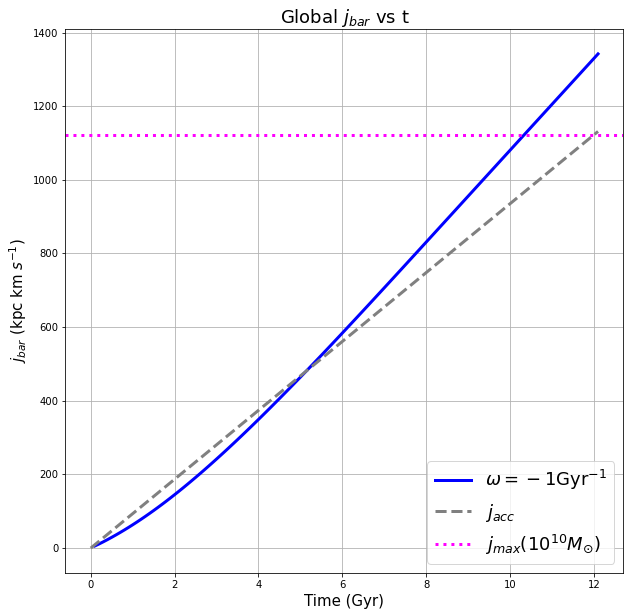

In [37]:
t_acc_array = np.array([-1,np.inf,25])
try_f_gas, try_j_bar = Half_definer(10**10, t_acc_array, at_t0=False, ns=1, cons=1)
j_accr = j_acc_def(j_maxer(10**10), M_times1, n=1, con=1)

fig = figure(figsize=(10,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, try_j_bar[0], label=r"$\omega = -1$Gyr$^{-1}$", color="blue", lw=3)
#frame.plot(M_times1, try_j_bar[1], label=r"$\omega = 0$Gyr$^{-1}$", color="red", lw=3)
#frame.plot(M_times1, try_j_bar[2], label=r"$\omega = 25$Gyr$^{-1}$", color="green", lw=3)
frame.plot(M_times1, j_accr, label=r"$j_{acc}$", linestyle="dashed", color="grey", lw=3)
frame.axhline(y=j_maxer(10**10), xmin=0, xmax=12, label=r"$j_{max}(10^{10}M_{\odot})$", linestyle="dotted", color="magenta", lw=3)
frame.set_title(r"Global $j_{bar}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$j_{bar}$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()

In [2]:
BARY = pd.read_csv('baryons.csv')

BARY['Mass(Msun)'] =  pd.to_numeric(BARY['Mass(Msun)'], errors='coerce')
BARY['e_Mass(Msun)'] =  pd.to_numeric(BARY['e_Mass(Msun)'], errors='coerce')
BARY['j'] =  pd.to_numeric(BARY['j'], errors='coerce')
BARY['e_j'] =  pd.to_numeric(BARY['e_j'], errors='coerce')
BARY['fgas'] =  pd.to_numeric(BARY['fgas'], errors='coerce')
BARY['e_fgas'] =  pd.to_numeric(BARY['e_fgas'], errors='coerce')

obs_Mbar = np.log10(BARY['Mass(Msun)'])
obs_Mbar_errors = BARY['e_Mass(Msun)']/BARY['Mass(Msun)']
obs_jbar = np.log10(BARY['j'])
obs_jbar_errors = BARY['e_j']/BARY['j']
obs_fgas = np.log10(BARY['fgas'])
obs_fgas_errors = BARY['e_fgas']/BARY['fgas']

HIX_logMstar = np.array([10.5, 10.7, 10.5, 10.5, 10.3, 10.2,  9.8, 10.1, 10.1, 10.1, 10.6, 10.5])
HIX_logMHI = np.log10(1.33 * 10**np.array([10.6, 10.7, 10.5, 10.5, 10.4, 10.3,  9.9, 10.3, 10.4, 10.3, 10.9, 10.5]))
HIX_logMbar = np.log10(10**HIX_logMstar + 10**HIX_logMHI)
HIX_fgas = (10**HIX_logMHI)/(10**HIX_logMbar)
HIX_jbar = np.array([4125.6, 3523.8, 5453.1, 4092.4, 3522.7, 3749.8, 1993. , 3196.7, 3388.2, 6377.8, 9764. , 4117.7])

In [33]:
log_M_bar_array = np.array([8,9,10,11])#np.linspace(8,11.5,4)
t_acc_array = np.array([3,10,25])#np.linspace(3,25,10)
f_gas_array = np.zeros((len(log_M_bar_array),len(t_acc_array)))
#print(f_gas_array)
j_bar_array = np.zeros((len(log_M_bar_array),len(t_acc_array)))
#print(j_bar_array[i,:])

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Half_definer(10**M, t_acc_array, ns=0.75, cons=1.5)#, res=10, Rmax=25)
    f_gas_array[i] = f_gas_temp
    j_bar_array[i] = j_bar_temp

/var/lib/condor/execute/dir_2861689/ipykernel_2864721/3632548923.py:51: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/3632548923.py:52: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/3632548923.py:53: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/3632548923.py:96: RuntimeWarning: invalid value encountered in true_divide
  j_bar_t1 = np.divide(Nominator_t1,Mass_time_bar_t1)#Nominator_t1/M_bar_array[0]#
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/3632548923.py:97: RuntimeWarn

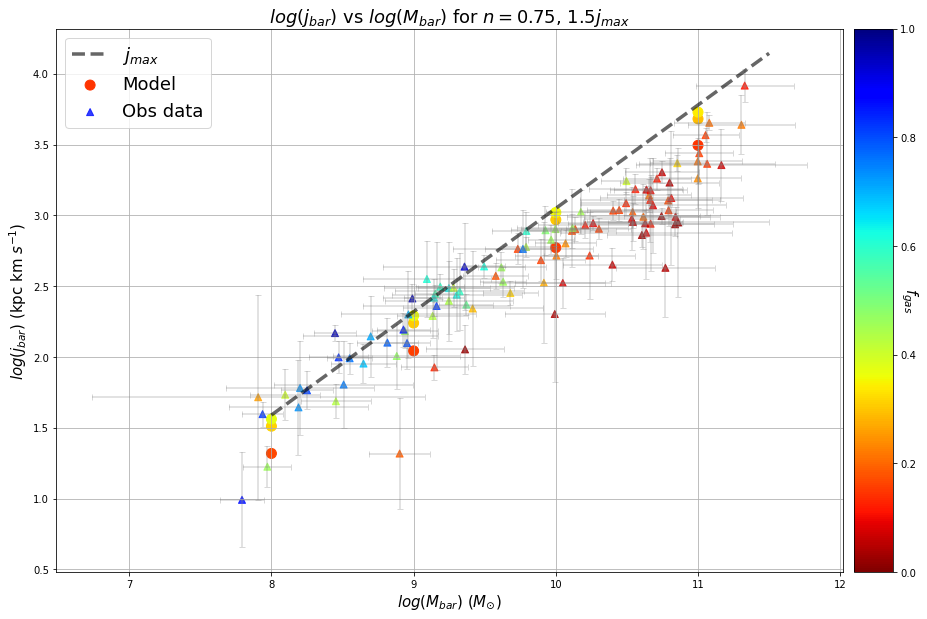

In [94]:
log_f_gas_array = np.log10(f_gas_array)
log_j_bar_array = np.log10(j_bar_array)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array, f_gas_array):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=100)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.plot(np.linspace(8,11.5,50), np.log10(j_maxer(10**np.linspace(8,11.5,50))), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ for $n=0.75$, $1.5j_{max}$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
#fig.savefig('graphs4/log j_bar vs log_M_bar (4 masses, 3 t_acc).png')
#fig.savefig('graphs4/log j_bar vs log_M_bar with Pavel (4 masses, 3 t_acc).png')

### $n=0.5$, $con=1$

In [75]:
log_M_bar_array = np.array([8,9,10,11])#np.linspace(8,11.5,4)
t_acc_array = np.array([3,10,25])
f_gas_array_1_05 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
#print(f_gas_array)
j_bar_array_1_05 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
#print(j_bar_array[i,:])

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Half_definer(10**M, t_acc_array, ns=0.5, cons=1)#, res=10, Rmax=25)
    f_gas_array_1_05[i] = f_gas_temp
    j_bar_array_1_05[i] = j_bar_temp

/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:51: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:52: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:53: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:96: RuntimeWarning: invalid value encountered in true_divide
  j_bar_t1 = np.divide(Nominator_t1,Mass_time_bar_t1)#Nominator_t1/M_bar_array[0]#
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:97: RuntimeWarn

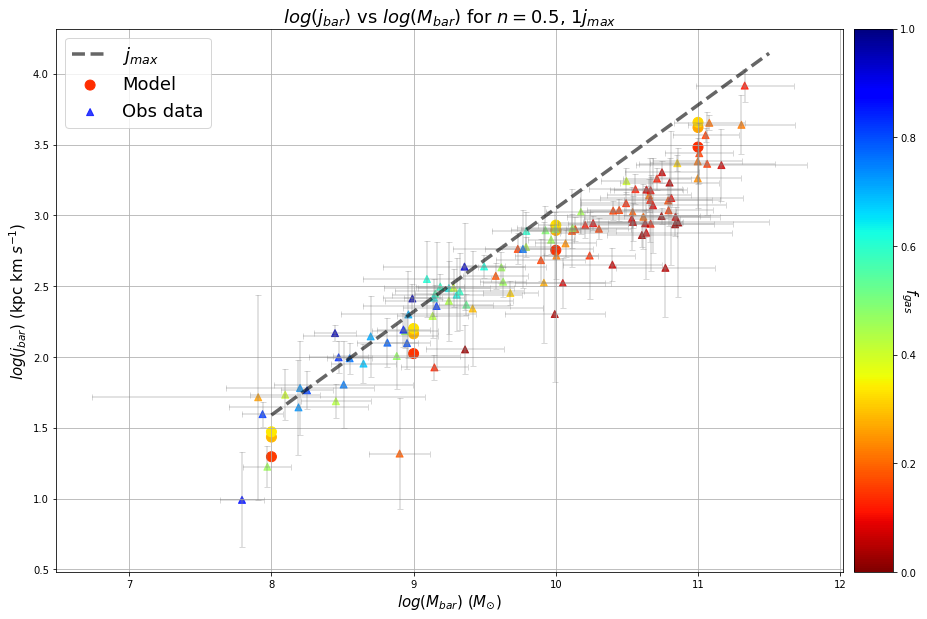

In [89]:
log_j_bar_array_1_05 = np.log10(j_bar_array_1_05)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_1_05, f_gas_array_1_05):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=100)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.plot(np.linspace(8,11.5,50), np.log10(j_maxer(10**np.linspace(8,11.5,50))), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ for $n=0.5$, $1j_{max}$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()

### $n=0.5$, $con=2$

In [83]:
log_M_bar_array = np.array([8,9,10,11])#np.linspace(8,11.5,4)
f_gas_array_2_05 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
#print(f_gas_array)
j_bar_array_2_05 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
#print(j_bar_array[i,:])

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Half_definer(10**M, t_acc_array, ns=0.5, cons=2)#, res=10, Rmax=25)
    f_gas_array_2_05[i] = f_gas_temp
    j_bar_array_2_05[i] = j_bar_temp

/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:51: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:52: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:53: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:96: RuntimeWarning: invalid value encountered in true_divide
  j_bar_t1 = np.divide(Nominator_t1,Mass_time_bar_t1)#Nominator_t1/M_bar_array[0]#
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:97: RuntimeWarn

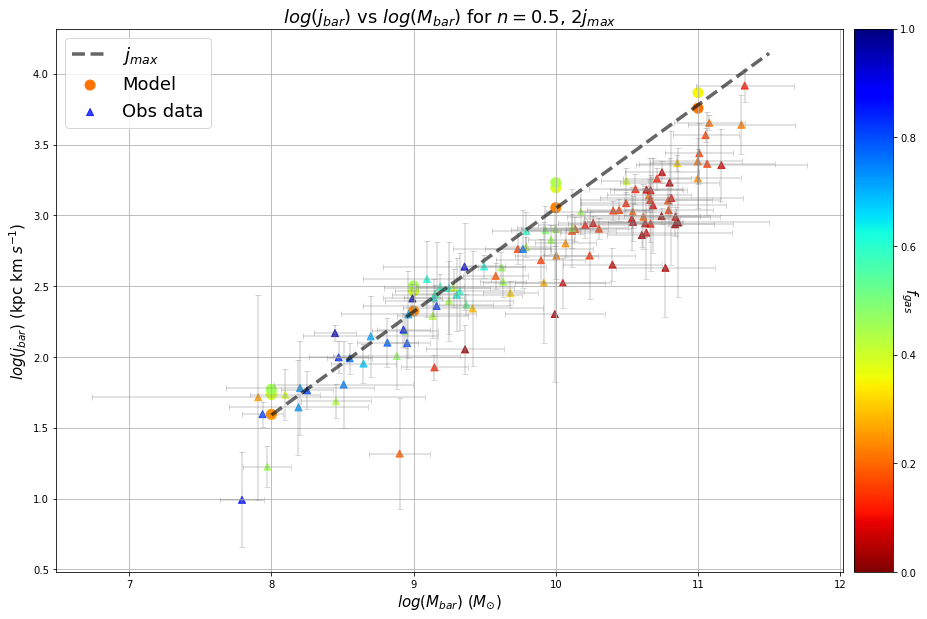

In [90]:
log_j_bar_array_2_05 = np.log10(j_bar_array_2_05)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_2_05, f_gas_array_2_05):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=100)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.plot(np.linspace(8,11.5,50), np.log10(j_maxer(10**np.linspace(8,11.5,50))), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ for $n=0.5$, $2j_{max}$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()

### $n=1$, $con=1$

In [79]:
log_M_bar_array = np.array([8,9,10,11])#np.linspace(8,11.5,4)
f_gas_array_1_1 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
#print(f_gas_array)
j_bar_array_1_1 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
#print(j_bar_array[i,:])

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Half_definer(10**M, t_acc_array, ns=1, cons=1)#, res=10, Rmax=25)
    f_gas_array_1_1[i] = f_gas_temp
    j_bar_array_1_1[i] = j_bar_temp

/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:51: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:52: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:53: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:96: RuntimeWarning: invalid value encountered in true_divide
  j_bar_t1 = np.divide(Nominator_t1,Mass_time_bar_t1)#Nominator_t1/M_bar_array[0]#
/var/lib/condor/execute/dir_2861689/ipykernel_2864721/1945494744.py:97: RuntimeWarn

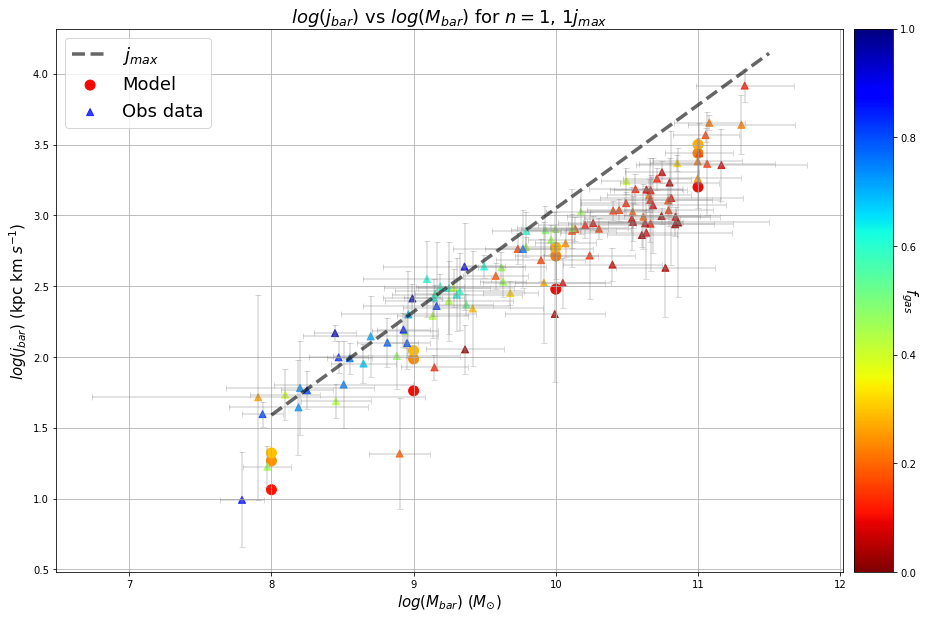

In [91]:
log_j_bar_array_1_1 = np.log10(j_bar_array_1_1)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_1_1, f_gas_array_1_1):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=100)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.plot(np.linspace(8,11.5,50), np.log10(j_maxer(10**np.linspace(8,11.5,50))), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ for $n=1$, $1j_{max}$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()

## Extended refiner (for negative $t_{acc}$)

In [39]:
def Ext_definer(Mbar, t_acc_arr, res=120, Rmax=100.1, at_t0=True, ns=1, ks=1):
    """Defines the fraction of gas and baryonic specific angular momentum arrays, with Mbar and t_acc as input"""
    
    r = np.arange(0,1000*Rmax,res)
    dr = res
    jmaxx = (Mbar**0.73)*10**(-4.25)
    
    M_sigma_t1 = Sigma_definer(r,t_acc_arr[0],Mbar,n=ns,con=ks)
    M_sigma_t2 = Sigma_definer(r,t_acc_arr[1],Mbar,n=ns,con=ks)
    M_sigma_t3 = Sigma_definer(r,t_acc_arr[2],Mbar,n=ns,con=ks)
    M_sigma_t4 = Sigma_definer(r,t_acc_arr[3],Mbar,n=ns,con=ks)
    M_sigma_t5 = Sigma_definer(r,t_acc_arr[4],Mbar,n=ns,con=ks)
    M_sigma_t6 = Sigma_definer(r,t_acc_arr[5],Mbar,n=ns,con=ks)
    M_sigma_t7 = Sigma_definer(r,t_acc_arr[6],Mbar,n=ns,con=ks)
    M_sigma_t8 = Sigma_definer(r,t_acc_arr[7],Mbar,n=ns,con=ks)
    #M_sigma_t9 = Sigma_definer(r,t_acc_arr[8],Mbar,n=ns,con=ks)
    
    M_sfr_t1 = A*(1-Rf)*M_sigma_t1**N
    M_sfr_t2 = A*(1-Rf)*M_sigma_t2**N
    M_sfr_t3 = A*(1-Rf)*M_sigma_t3**N
    M_sfr_t4 = A*(1-Rf)*M_sigma_t4**N
    M_sfr_t5 = A*(1-Rf)*M_sigma_t5**N
    M_sfr_t6 = A*(1-Rf)*M_sigma_t6**N
    M_sfr_t7 = A*(1-Rf)*M_sigma_t7**N
    M_sfr_t8 = A*(1-Rf)*M_sigma_t8**N
    #M_sfr_t9 = A*(1-Rf)*M_sigma_t9**N
    
    r = r.reshape(len(r),1)
    
    Mass_gas_summed_t1 = 2*np.pi*spint.simpson(r*M_sigma_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r*M_sigma_t1, axis=0)
    Mass_gas_summed_t2 = 2*np.pi*spint.simpson(r*M_sigma_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])#2*np.pi*spint.simpson(r*M_sigma_t2[:,-1], dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t2, axis=0)
    Mass_gas_summed_t3 = 2*np.pi*spint.simpson(r*M_sigma_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])#2*np.pi*spint.simpson(r*M_sigma_t3[:,-1], dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t3, axis=0)
    Mass_gas_summed_t4 = 2*np.pi*spint.simpson(r*M_sigma_t4, dx=dr, axis=0)
    Mass_gas_summed_t5 = 2*np.pi*spint.simpson(r*M_sigma_t5, dx=dr, axis=0)
    Mass_gas_summed_t6 = 2*np.pi*spint.simpson(r*M_sigma_t6, dx=dr, axis=0)
    Mass_gas_summed_t7 = 2*np.pi*spint.simpson(r*M_sigma_t7, dx=dr, axis=0)
    Mass_gas_summed_t8 = 2*np.pi*spint.simpson(r*M_sigma_t8, dx=dr, axis=0)
    #Mass_gas_summed_t9 = 2*np.pi*spint.simpson(r*M_sigma_t9, dx=dr, axis=0)
    
    Mass_sfr_summed_t1 = 2*np.pi*spint.simpson(r*M_sfr_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t1, axis=0)
    Mass_sfr_summed_t2 = 2*np.pi*spint.simpson(r*M_sfr_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t2, axis=0)
    Mass_sfr_summed_t3 = 2*np.pi*spint.simpson(r*M_sfr_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t3, axis=0)
    Mass_sfr_summed_t4 = 2*np.pi*spint.simpson(r*M_sfr_t4, dx=dr, axis=0)
    Mass_sfr_summed_t5 = 2*np.pi*spint.simpson(r*M_sfr_t5, dx=dr, axis=0)
    Mass_sfr_summed_t6 = 2*np.pi*spint.simpson(r*M_sfr_t6, dx=dr, axis=0)
    Mass_sfr_summed_t7 = 2*np.pi*spint.simpson(r*M_sfr_t7, dx=dr, axis=0)
    Mass_sfr_summed_t8 = 2*np.pi*spint.simpson(r*M_sfr_t8, dx=dr, axis=0)
    #Mass_sfr_summed_t9 = 2*np.pi*spint.simpson(r*M_sfr_t9, dx=dr, axis=0)
    
    Mass_time_star_t1 = dt*np.cumsum(Mass_sfr_summed_t1)
    Mass_time_star_t2 = dt*np.cumsum(Mass_sfr_summed_t2)
    Mass_time_star_t3 = dt*np.cumsum(Mass_sfr_summed_t3)
    Mass_time_star_t4 = dt*np.cumsum(Mass_sfr_summed_t4)
    Mass_time_star_t5 = dt*np.cumsum(Mass_sfr_summed_t5)
    Mass_time_star_t6 = dt*np.cumsum(Mass_sfr_summed_t6)
    Mass_time_star_t7 = dt*np.cumsum(Mass_sfr_summed_t7)
    Mass_time_star_t8 = dt*np.cumsum(Mass_sfr_summed_t8)
    #Mass_time_star_t9 = dt*np.cumsum(Mass_sfr_summed_t9)

    Mass_time_bar_t1 = [np.sum(x) for x in zip(Mass_time_star_t1, Mass_gas_summed_t1)]#Mass_gas_summed_t1+Mass_time_star_t1 #
    Mass_time_bar_t2 = [np.sum(x) for x in zip(Mass_time_star_t2, Mass_gas_summed_t2)]#Mass_gas_summed_t2+Mass_time_star_t2 #
    Mass_time_bar_t3 = [np.sum(x) for x in zip(Mass_time_star_t3, Mass_gas_summed_t3)]#Mass_gas_summed_t3+Mass_time_star_t3 #
    Mass_time_bar_t4 = [np.sum(x) for x in zip(Mass_time_star_t4, Mass_gas_summed_t4)]
    Mass_time_bar_t5 = [np.sum(x) for x in zip(Mass_time_star_t5, Mass_gas_summed_t5)]
    Mass_time_bar_t6 = [np.sum(x) for x in zip(Mass_time_star_t6, Mass_gas_summed_t6)]
    Mass_time_bar_t7 = [np.sum(x) for x in zip(Mass_time_star_t7, Mass_gas_summed_t7)]
    Mass_time_bar_t8 = [np.sum(x) for x in zip(Mass_time_star_t8, Mass_gas_summed_t8)]
    #Mass_time_bar_t9 = [np.sum(x) for x in zip(Mass_time_star_t9, Mass_gas_summed_t9)]
    
    f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
    f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
    f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
    f_global_gas_t4 = np.divide(Mass_gas_summed_t4, Mass_time_bar_t4)
    f_global_gas_t5 = np.divide(Mass_gas_summed_t5, Mass_time_bar_t5)
    f_global_gas_t6 = np.divide(Mass_gas_summed_t6, Mass_time_bar_t6)
    f_global_gas_t7 = np.divide(Mass_gas_summed_t7, Mass_time_bar_t7)
    f_global_gas_t8 = np.divide(Mass_gas_summed_t8, Mass_time_bar_t8)
    #f_global_gas_t9 = np.divide(Mass_gas_summed_t9, Mass_time_bar_t9)
    
    #M_bar_array = np.zeros((len(t_acc_arr),len(M_times1)))
    #for i, t_accr in enumerate(t_acc_arr):
    #    M_bar_array[i] = M_def(Mbar, t_accr, t=M_times1)
    
    #j_acc_array = np.zeros((len(t_acc_arr),len(M_times1)))
    #for i in range(len(t_acc_arr)):
    #    j_acc_array[i] = j_acc_def(j_max, M_times1)
     
    #v_rot_array = v_rot_def(r_btfr_def(M_bar_array, j_acc_array), j_max, M_times1, Mbar)
    Mbar_allsame = np.full(Mass_time_bar_t1.shape, Mass_time_bar_t1[-1])
    v_rot = v_btfr_def(Mbar_allsame)
    #v_rot_t2 = (np.array(Mass_time_bar_t2)/Ag)**0.25
    #v_rot_t3 = (np.array(Mass_time_bar_t3)/Ag)**0.25
    #v_rot_t4 = (np.array(Mass_time_bar_t4)/Ag)**0.25
    #v_rot_t5 = (np.array(Mass_time_bar_t5)/Ag)**0.25
    #v_rot_t6 = (np.array(Mass_time_bar_t6)/Ag)**0.25
    #v_rot_t7 = (np.array(Mass_time_bar_t7)/Ag)**0.25
    #v_rot_t8 = (np.array(Mass_time_bar_t8)/Ag)**0.25
    #v_rot_t9 = (np.array(Mass_time_bar_t9)/Ag)**0.25
    
    Nominator_gas_t1 = 2*np.pi*spint.simpson(r**2*M_sigma_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t1, axis=0)
    Nominator_gas_t2 = 2*np.pi*spint.simpson(r**2*M_sigma_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t2, axis=0)
    Nominator_gas_t3 = 2*np.pi*spint.simpson(r**2*M_sigma_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t3, axis=0)
    Nominator_gas_t4 = 2*np.pi*spint.simpson(r**2*M_sigma_t4, dx=dr, axis=0)
    Nominator_gas_t5 = 2*np.pi*spint.simpson(r**2*M_sigma_t5, dx=dr, axis=0)
    Nominator_gas_t6 = 2*np.pi*spint.simpson(r**2*M_sigma_t6, dx=dr, axis=0)
    Nominator_gas_t7 = 2*np.pi*spint.simpson(r**2*M_sigma_t7, dx=dr, axis=0)
    Nominator_gas_t8 = 2*np.pi*spint.simpson(r**2*M_sigma_t8, dx=dr, axis=0)
    #Nominator_gas_t9 = 2*np.pi*spint.simpson(r**2*M_sigma_t9, dx=dr, axis=0)
    
    sfr_r_squared_t1 = 2*np.pi*spint.simpson(r**2*M_sfr_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t1, axis=0)
    sfr_r_squared_t2 = 2*np.pi*spint.simpson(r**2*M_sfr_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t2, axis=0)
    sfr_r_squared_t3 = 2*np.pi*spint.simpson(r**2*M_sfr_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t3, axis=0)
    sfr_r_squared_t4 = 2*np.pi*spint.simpson(r**2*M_sfr_t4, dx=dr, axis=0)
    sfr_r_squared_t5 = 2*np.pi*spint.simpson(r**2*M_sfr_t5, dx=dr, axis=0)
    sfr_r_squared_t6 = 2*np.pi*spint.simpson(r**2*M_sfr_t6, dx=dr, axis=0)
    sfr_r_squared_t7 = 2*np.pi*spint.simpson(r**2*M_sfr_t7, dx=dr, axis=0)
    sfr_r_squared_t8 = 2*np.pi*spint.simpson(r**2*M_sfr_t8, dx=dr, axis=0)
    #sfr_r_squared_t9 = 2*np.pi*spint.simpson(r**2*M_sfr_t9, dx=dr, axis=0)
    
    Nominator_star_t1 = dt*np.cumsum(sfr_r_squared_t1)
    Nominator_star_t2 = dt*np.cumsum(sfr_r_squared_t2)
    Nominator_star_t3 = dt*np.cumsum(sfr_r_squared_t3)
    Nominator_star_t4 = dt*np.cumsum(sfr_r_squared_t4)
    Nominator_star_t5 = dt*np.cumsum(sfr_r_squared_t5)
    Nominator_star_t6 = dt*np.cumsum(sfr_r_squared_t6)
    Nominator_star_t7 = dt*np.cumsum(sfr_r_squared_t7)
    Nominator_star_t8 = dt*np.cumsum(sfr_r_squared_t8)
    #Nominator_star_t9 = dt*np.cumsum(sfr_r_squared_t9)
    
    Nominator_bar_t1 = [np.sum(x) for x in zip(Nominator_star_t1, Nominator_gas_t1)]#Nominator_gas_t1+Nominator_star_t1#
    Nominator_bar_t2 = [np.sum(x) for x in zip(Nominator_star_t2, Nominator_gas_t2)]#Nominator_gas_t2+Nominator_star_t2#
    Nominator_bar_t3 = [np.sum(x) for x in zip(Nominator_star_t3, Nominator_gas_t3)]#Nominator_gas_t3+Nominator_star_t3#
    Nominator_bar_t4 = [np.sum(x) for x in zip(Nominator_star_t4, Nominator_gas_t4)]
    Nominator_bar_t5 = [np.sum(x) for x in zip(Nominator_star_t5, Nominator_gas_t5)]
    Nominator_bar_t6 = [np.sum(x) for x in zip(Nominator_star_t6, Nominator_gas_t6)]
    Nominator_bar_t7 = [np.sum(x) for x in zip(Nominator_star_t7, Nominator_gas_t7)]
    Nominator_bar_t8 = [np.sum(x) for x in zip(Nominator_star_t8, Nominator_gas_t8)]
    #Nominator_bar_t9 = [np.sum(x) for x in zip(Nominator_star_t9, Nominator_gas_t9)]
    
    Nominator_t1 = v_rot*Nominator_bar_t1#v_rot_array[0]*Nominator_bar_t1##v_rot_t1*Nominator_bar_t1
    Nominator_t2 = v_rot*Nominator_bar_t2#v_rot_array[1]*Nominator_bar_t2##v_rot_t2*Nominator_bar_t2
    Nominator_t3 = v_rot*Nominator_bar_t3#v_rot_array[2]*Nominator_bar_t3##v_rot_t3*Nominator_bar_t3
    Nominator_t4 = v_rot*Nominator_bar_t4#v_rot_array[3]*Nominator_bar_t4
    Nominator_t5 = v_rot*Nominator_bar_t5#v_rot_array[4]*Nominator_bar_t5
    Nominator_t6 = v_rot*Nominator_bar_t6#v_rot_array[5]*Nominator_bar_t6
    Nominator_t7 = v_rot*Nominator_bar_t7#v_rot_array[6]*Nominator_bar_t7
    Nominator_t8 = v_rot*Nominator_bar_t8#v_rot_array[7]*Nominator_bar_t8
    #Nominator_t9 = v_rot_t9*Nominator_bar_t9

    j_bar_t1 = np.divide(Nominator_t1,Mass_time_bar_t1)#Nominator_t1/M_bar_array[0]#
    j_bar_t2 = np.divide(Nominator_t2,Mass_time_bar_t2)#Nominator_t2/M_bar_array[1]#
    j_bar_t3 = np.divide(Nominator_t3,Mass_time_bar_t3)#Nominator_t3/M_bar_array[2]#
    j_bar_t4 = np.divide(Nominator_t4,Mass_time_bar_t4)
    j_bar_t5 = np.divide(Nominator_t5,Mass_time_bar_t5)
    j_bar_t6 = np.divide(Nominator_t6,Mass_time_bar_t6)
    j_bar_t7 = np.divide(Nominator_t7,Mass_time_bar_t7)
    j_bar_t8 = np.divide(Nominator_t8,Mass_time_bar_t8)
    #j_bar_t9 = np.divide(Nominator_t9,Mass_time_bar_t9)
    
    if (at_t0==True):
        f_gas_array = np.array([f_global_gas_t1[-1], f_global_gas_t2[-1], f_global_gas_t3[-1], f_global_gas_t4[-1], f_global_gas_t5[-1], f_global_gas_t6[-1], f_global_gas_t7[-1], f_global_gas_t8[-1]])
        j_bar_array = np.array([j_bar_t1[-1]/1000, j_bar_t2[-1]/1000, j_bar_t3[-1]/1000, j_bar_t4[-1]/1000, j_bar_t5[-1]/1000, j_bar_t6[-1]/1000, j_bar_t7[-1]/1000, j_bar_t8[-1]/1000])
    else:
        f_gas_array = np.array([f_global_gas_t1, f_global_gas_t2, f_global_gas_t3, f_global_gas_t4, f_global_gas_t5, f_global_gas_t6, f_global_gas_t7, f_global_gas_t8])
        j_bar_array = np.array([j_bar_t1/1000, j_bar_t2/1000, j_bar_t3/1000, j_bar_t4/1000, j_bar_t5/1000, j_bar_t6/1000, j_bar_t7/1000, j_bar_t8/1000])
    
    return f_gas_array, j_bar_array

### $n=1$, $con=2$, $t_{acc}=-25,-10,-3,-1,1,3,10,25$

In [30]:
log_M_bar_array = np.array([8,9,10,11])#np.linspace(8,11.5,4)
t_acc_array_ext = np.array([-25,-10,-3,-1,1,3,10,25])
f_gas_array_2_1 = np.zeros((len(log_M_bar_array),len(t_acc_array_ext)))
#print(f_gas_array)
j_bar_array_2_1 = np.zeros((len(log_M_bar_array),len(t_acc_array_ext)))
#print(j_bar_array[i,:])

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Ext_definer(10**M, t_acc_array_ext, ns=1, ks=2)#, res=10, Rmax=25)
    f_gas_array_2_1[i] = f_gas_temp
    j_bar_array_2_1[i] = j_bar_temp

/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:64: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:65: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:66: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:67: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t4 = np.divide(Mass_gas_summed_t4, Mass_time_bar_t4)
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:68: RuntimeWarning: invalid va

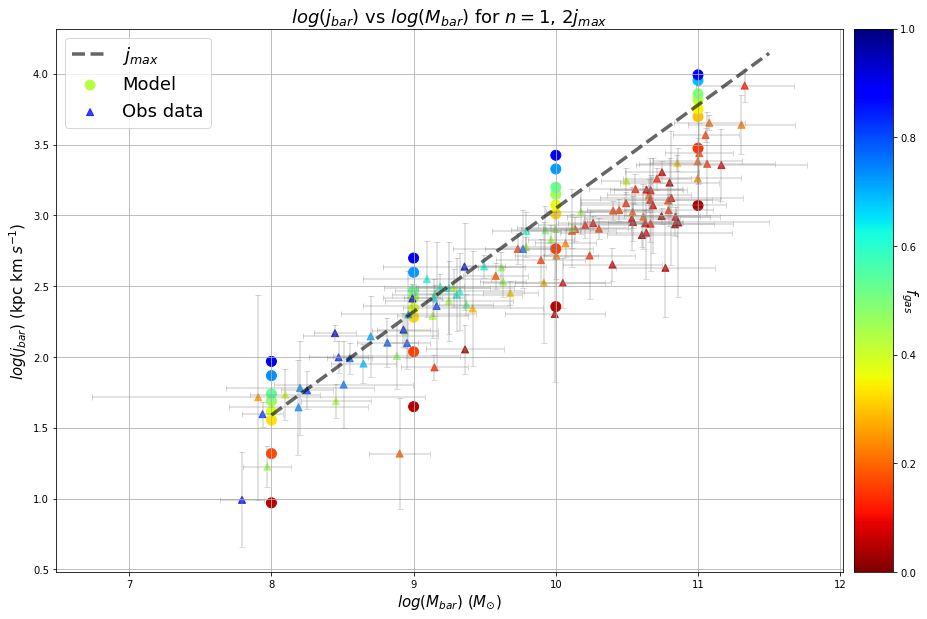

In [33]:
log_j_bar_array_2_1 = np.log10(j_bar_array_2_1)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_2_1, f_gas_array_2_1):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=100)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.plot(np.linspace(8,11.5,50), np.log10(j_maxer(10**np.linspace(8,11.5,50))), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ for $n=1$, $2j_{max}$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/log j_bar vs log_M_bar with Pavel (4 masses, 8 t_acc, n=1, con=2).png')

### $n=1$, $k=1$, $t_{acc}=-25,-10,-3,-1,1,3,10,25$

In [36]:
log_M_bar_array = np.array([8,9,10,11])#np.linspace(8,11.5,4)
t_acc_array_ext = np.array([-25,-10,-3,-1,1,3,10,25])
f_gas_array_1_1 = np.zeros((len(log_M_bar_array),len(t_acc_array_ext)))
#print(f_gas_array)
j_bar_array_1_1 = np.zeros((len(log_M_bar_array),len(t_acc_array_ext)))
#print(j_bar_array[i,:])

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Ext_definer(10**M, t_acc_array_ext, ns=1, ks=1)#, res=10, Rmax=25)
    f_gas_array_1_1[i] = f_gas_temp
    j_bar_array_1_1[i] = j_bar_temp

/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:64: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:65: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:66: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:67: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t4 = np.divide(Mass_gas_summed_t4, Mass_time_bar_t4)
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:68: RuntimeWarning: invalid va

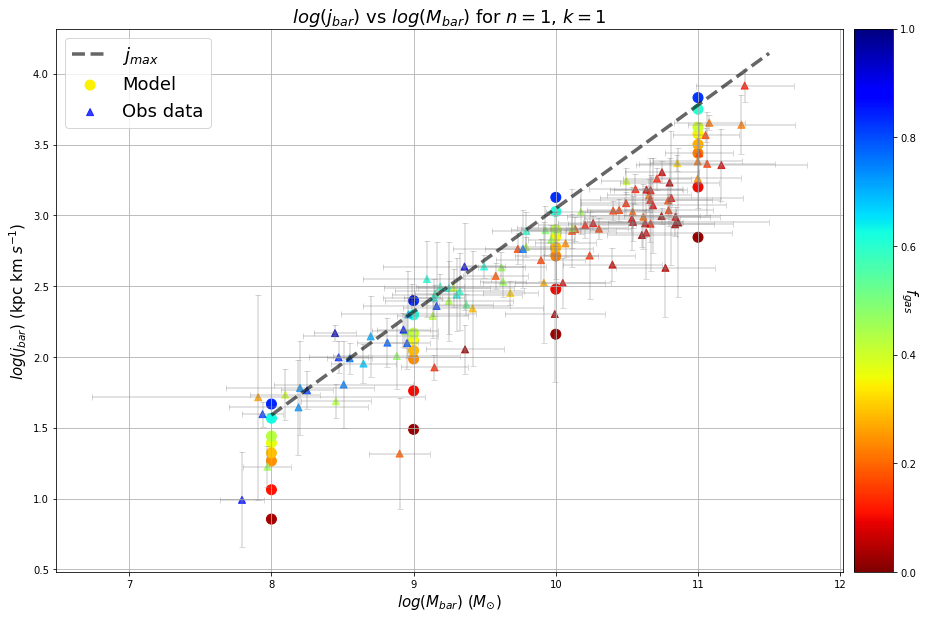

In [41]:
log_j_bar_array_1_1 = np.log10(j_bar_array_1_1)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_1_1, f_gas_array_1_1):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=100)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.plot(np.linspace(8,11.5,50), np.log10(j_maxer(10**np.linspace(8,11.5,50))), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ for $n=1$, $k=1$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/log j_bar vs log_M_bar with Pavel (4 masses, 8 t_acc, n=1, con=1).png')

In [29]:
t_acc_array_ext = np.array([1,3,10,25,-25,-10,-3,-1])
try_f_gas, try_j_bar = Ext_definer(10**10, t_acc_array_ext, at_t0=False, ns=1, ks=1)
j_accr = j_acc_def(j_maxer(10**10), M_times1, n=1, con=1)

/var/lib/condor/execute/dir_1606852/ipykernel_1606909/1747573955.py:70: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_1606852/ipykernel_1606909/1747573955.py:71: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_1606852/ipykernel_1606909/1747573955.py:72: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_1606852/ipykernel_1606909/1747573955.py:73: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t4 = np.divide(Mass_gas_summed_t4, Mass_time_bar_t4)
/var/lib/condor/execute/dir_1606852/ipykernel_1606909/1747573955.py:74: RuntimeWarning: invalid va

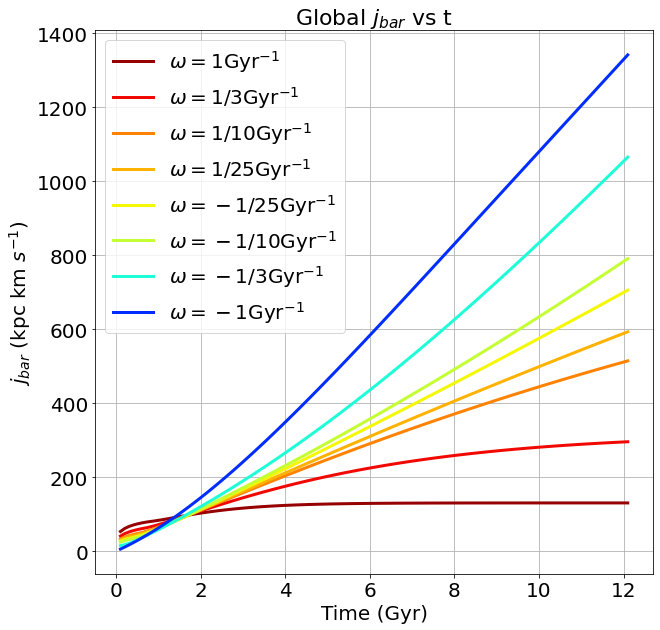

In [30]:
cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")

fig = figure(figsize=(10,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, try_j_bar[0], label=r"$\omega = 1$Gyr$^{-1}$", color=cmap(try_f_gas[0][-1]), lw=3)
frame.plot(M_times1, try_j_bar[1], label=r"$\omega = 1/3$Gyr$^{-1}$", color=cmap(try_f_gas[1][-1]), lw=3)
frame.plot(M_times1, try_j_bar[2], label=r"$\omega = 1/10$Gyr$^{-1}$", color=cmap(try_f_gas[2][-1]), lw=3)
frame.plot(M_times1, try_j_bar[3], label=r"$\omega = 1/25$Gyr$^{-1}$", color=cmap(try_f_gas[3][-1]), lw=3)
#frame.plot(M_times1, try_j_bar[4], label=r"$\omega = 0$Gyr$^{-1}$", color=cmap(try_f_gas[4][-1]), lw=3)
frame.plot(M_times1, try_j_bar[4], label=r"$\omega = -1/25$Gyr$^{-1}$", color=cmap(try_f_gas[4][-1]), lw=3)
frame.plot(M_times1, try_j_bar[5], label=r"$\omega = -1/10$Gyr$^{-1}$", color=cmap(try_f_gas[5][-1]), lw=3)
frame.plot(M_times1, try_j_bar[6], label=r"$\omega = -1/3$Gyr$^{-1}$", color=cmap(try_f_gas[6][-1]), lw=3)
frame.plot(M_times1, try_j_bar[7], label=r"$\omega = -1$Gyr$^{-1}$", color=cmap(try_f_gas[7][-1]), lw=3)
#frame.plot(M_times1, j_accr, label=r"$j_{acc}$", linestyle="dashed", color="grey", lw=3)
#frame.axhline(y=j_maxer(10**10), xmin=0, xmax=12, label=r"$j_{max}(10^{10}M_{\odot})$", linestyle="dotted", color="magenta", lw=3)
frame.set_title(r"Global $j_{bar}$ vs t", fontsize = 22)
frame.set_xlabel("Time (Gyr)", fontsize = 20)
frame.set_ylabel(r"$j_{bar}$ (kpc km $s^{-1}$)", fontsize = 20)
frame.tick_params(axis="both", labelsize=20)
frame.legend(prop={'size': 20})
frame.grid()
show()

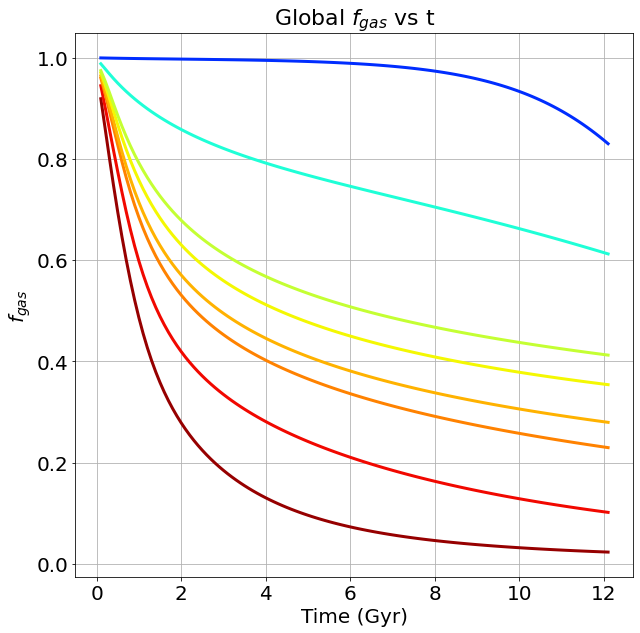

In [32]:
fig = figure(figsize=(10,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, try_f_gas[0], label=r"$\omega = 1$Gyr$^{-1}$", color=cmap(try_f_gas[0][-1]), lw=3)
frame.plot(M_times1, try_f_gas[1], label=r"$\omega = 1/3$Gyr$^{-1}$", color=cmap(try_f_gas[1][-1]), lw=3)
frame.plot(M_times1, try_f_gas[2], label=r"$\omega = 1/10$Gyr$^{-1}$", color=cmap(try_f_gas[2][-1]), lw=3)
frame.plot(M_times1, try_f_gas[3], label=r"$\omega = 1/25$Gyr$^{-1}$", color=cmap(try_f_gas[3][-1]), lw=3)
#frame.plot(M_times1, try_f_gas[4], label=r"$\omega = 0$Gyr$^{-1}$", color=cmap(try_f_gas[4][-1]), lw=3)
frame.plot(M_times1, try_f_gas[4], label=r"$\omega = -1/25$Gyr$^{-1}$", color=cmap(try_f_gas[4][-1]), lw=3)
frame.plot(M_times1, try_f_gas[5], label=r"$\omega = -1/10$Gyr$^{-1}$", color=cmap(try_f_gas[5][-1]), lw=3)
frame.plot(M_times1, try_f_gas[6], label=r"$\omega = -1/3$Gyr$^{-1}$", color=cmap(try_f_gas[6][-1]), lw=3)
frame.plot(M_times1, try_f_gas[7], label=r"$\omega = -1$Gyr$^{-1}$", color=cmap(try_f_gas[7][-1]), lw=3)
#frame.plot(M_times1, j_accr, label=r"$j_{acc}$", linestyle="dashed", color="grey", lw=3)
#frame.axhline(y=j_maxer(10**10), xmin=0, xmax=12, label=r"$j_{max}(10^{10}M_{\odot})$", linestyle="dotted", color="magenta", lw=3)
frame.set_title(r"Global $f_{gas}$ vs t", fontsize = 22)
frame.set_xlabel("Time (Gyr)", fontsize = 20)
frame.set_ylabel(r"$f_{gas}$", fontsize = 20)
frame.tick_params(axis="both", labelsize=20)
#frame.legend(prop={'size': 20})
frame.grid()
show()

## $\dot{M}_{acc}$ vs t

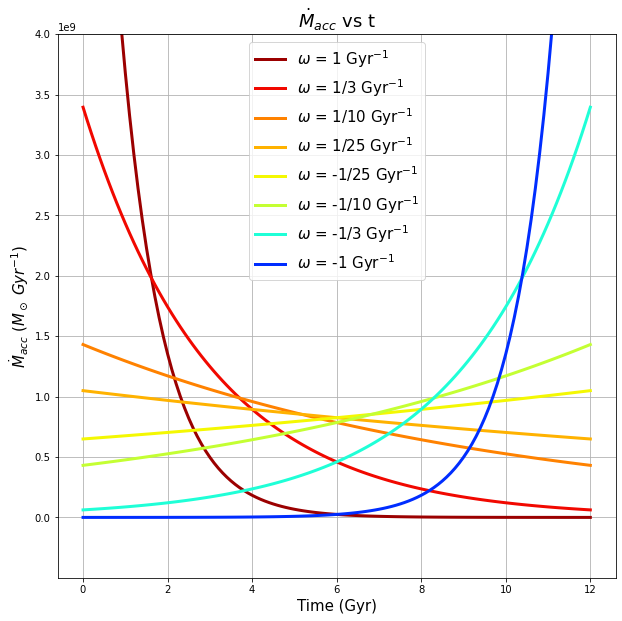

In [56]:
def M_acc_dot_def(M_bar, t, t_acc):
    return C_def(M_bar, t_acc)*np.exp(-t/t_acc)

t_acc_array_ext = np.array([1,3,10,25,-25,-10,-3,-1])

fig = figure(figsize=(10,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)
for i in range(len(t_acc_array_ext)):
    frame.plot(M_times, M_acc_dot_def(10**10, M_times, t_acc_array_ext[i]), label=r"$\omega$ = "+f"{Fraction(1,t_acc_array_ext[i])}"+r" Gyr$^{-1}$", color=cmap(try_f_gas[i][-1]), lw=3)
frame.set_title(r"$\dot{M}_{acc}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$\dot{M}_{acc}$ $(M_\odot\ Gyr^{-1})$", fontsize = 15)
frame.set_ylim(ymax=0.4e10)
frame.legend(prop={'size': 15})
frame.grid()
show()
fig.savefig('graphs4/M_acc_dot vs t (n=1,k=1)'+f'_{np.log10(M_bar_t0)}'+'.png')

### $n=0.5$, $k=1$, $t_{acc}=-25,-10,-3,-1,1,3,10,25$

In [38]:
log_M_bar_array = np.array([8,9,10,11])#np.linspace(8,11.5,4)
t_acc_array_ext = np.array([-25,-10,-3,-1,1,3,10,25])
f_gas_array_1_05 = np.zeros((len(log_M_bar_array),len(t_acc_array_ext)))
#print(f_gas_array)
j_bar_array_1_05 = np.zeros((len(log_M_bar_array),len(t_acc_array_ext)))
#print(j_bar_array[i,:])

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Ext_definer(10**M, t_acc_array_ext, ns=0.5, ks=1)#, res=10, Rmax=25)
    f_gas_array_1_05[i] = f_gas_temp
    j_bar_array_1_05[i] = j_bar_temp

/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:64: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:65: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:66: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:67: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas_t4 = np.divide(Mass_gas_summed_t4, Mass_time_bar_t4)
/var/lib/condor/execute/dir_2565397/ipykernel_2565526/1891515674.py:68: RuntimeWarning: invalid va

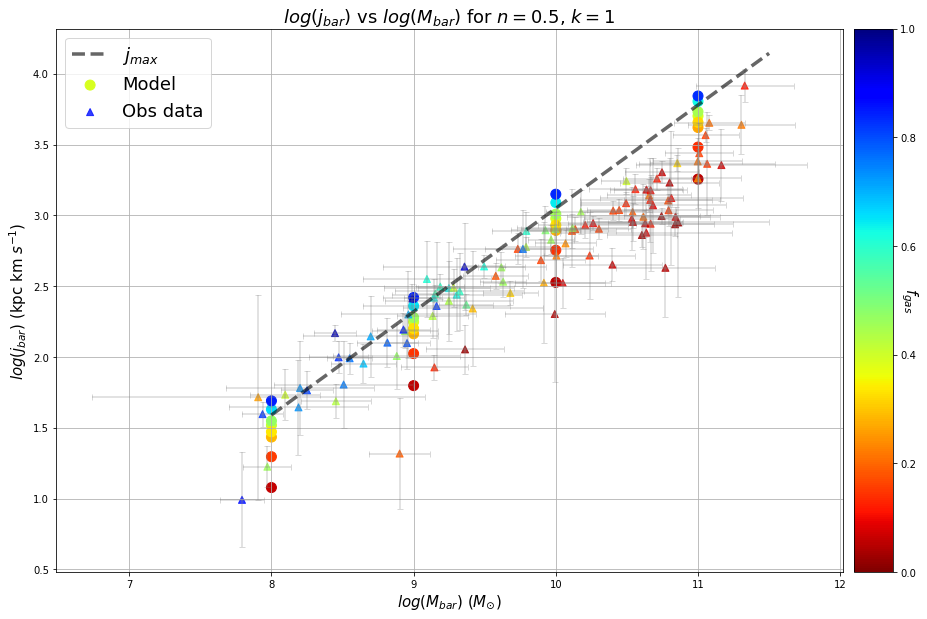

In [40]:
log_j_bar_array_1_05 = np.log10(j_bar_array_1_05)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_1_05, f_gas_array_1_05):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=100)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.plot(np.linspace(8,11.5,50), np.log10(j_maxer(10**np.linspace(8,11.5,50))), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ for $n=0.5$, $k=1$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/log j_bar vs log_M_bar with Pavel (4 masses, 8 t_acc, n=0.5, con=1).png')

## Final Plot (10 $t_{acc}$ and 50 $M_{bar}$)

In [28]:
def Full_definer(Mbar, t_acc_arr, res=120, Rmax=100.1, at_t0=True, ns=1, ks=1):
    """Defines the fraction of gas and baryonic specific angular momentum arrays, with Mbar and t_acc as input"""
    
    r = np.arange(0,1000*Rmax,res)
    dr = res
    jmaxx = (Mbar**0.73)*10**(-4.25)
    
    #M_sigma_r = np.zeros(10,len(r))
    #M_sfr_r = np.zeros(10,len(r))
    #for i,r_acc in enumerate(r_acc_array):
    #    M_sigma_r[i] = Sigma_definer(r,r_acc,t_acc,C)
    #    M_sfr_r[i] = A*(1-Rf)*M_sigma_r[i]**N
    
    M_sigma_t1 = Sigma_definer(r,t_acc_arr[0],Mbar,n=ns,con=ks)
    M_sigma_t2 = Sigma_definer(r,t_acc_arr[1],Mbar,n=ns,con=ks)
    M_sigma_t3 = Sigma_definer(r,t_acc_arr[2],Mbar,n=ns,con=ks)
    M_sigma_t4 = Sigma_definer(r,t_acc_arr[3],Mbar,n=ns,con=ks)
    M_sigma_t5 = Sigma_definer(r,t_acc_arr[4],Mbar,n=ns,con=ks)
    M_sigma_t6 = Sigma_definer(r,t_acc_arr[5],Mbar,n=ns,con=ks)
    M_sigma_t7 = Sigma_definer(r,t_acc_arr[6],Mbar,n=ns,con=ks)
    M_sigma_t8 = Sigma_definer(r,t_acc_arr[7],Mbar,n=ns,con=ks)
    M_sigma_t9 = Sigma_definer(r,t_acc_arr[8],Mbar,n=ns,con=ks)
    M_sigma_t10 = Sigma_definer(r,t_acc_arr[9],Mbar,n=ns,con=ks)
    
    M_sfr_t1 = A*(1-Rf)*M_sigma_t1**N
    M_sfr_t2 = A*(1-Rf)*M_sigma_t2**N
    M_sfr_t3 = A*(1-Rf)*M_sigma_t3**N
    M_sfr_t4 = A*(1-Rf)*M_sigma_t4**N
    M_sfr_t5 = A*(1-Rf)*M_sigma_t5**N
    M_sfr_t6 = A*(1-Rf)*M_sigma_t6**N
    M_sfr_t7 = A*(1-Rf)*M_sigma_t7**N
    M_sfr_t8 = A*(1-Rf)*M_sigma_t8**N
    M_sfr_t9 = A*(1-Rf)*M_sigma_t9**N
    M_sfr_t10 = A*(1-Rf)*M_sigma_t10**N
    
    r = r.reshape(len(r),1)
    #Mass_gas_summed_r = np.zeros(10,len(r))
    #for i in range(len(r_acc_array)):
    #    Mass_gas_summed_r[i] = 2*np.pi*dr*np.sum(r*M_sigma_r[i], axis=0)
    
    Mass_gas_summed_t1 = 2*np.pi*spint.simpson(r*M_sigma_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r*M_sigma_t1, axis=0)
    Mass_gas_summed_t2 = 2*np.pi*spint.simpson(r*M_sigma_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])#2*np.pi*spint.simpson(r*M_sigma_t2[:,-1], dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t2, axis=0)
    Mass_gas_summed_t3 = 2*np.pi*spint.simpson(r*M_sigma_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t1[:,-1])#2*np.pi*spint.simpson(r*M_sigma_t3[:,-1], dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sigma_t3, axis=0)
    Mass_gas_summed_t4 = 2*np.pi*spint.simpson(r*M_sigma_t4, dx=dr, axis=0)
    Mass_gas_summed_t5 = 2*np.pi*spint.simpson(r*M_sigma_t5, dx=dr, axis=0)
    Mass_gas_summed_t6 = 2*np.pi*spint.simpson(r*M_sigma_t6, dx=dr, axis=0)
    Mass_gas_summed_t7 = 2*np.pi*spint.simpson(r*M_sigma_t7, dx=dr, axis=0)
    Mass_gas_summed_t8 = 2*np.pi*spint.simpson(r*M_sigma_t8, dx=dr, axis=0)
    Mass_gas_summed_t9 = 2*np.pi*spint.simpson(r*M_sigma_t9, dx=dr, axis=0)
    Mass_gas_summed_t10 = 2*np.pi*spint.simpson(r*M_sigma_t10, dx=dr, axis=0)
    
    Mass_sfr_summed_t1 = 2*np.pi*spint.simpson(r*M_sfr_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t1, axis=0)
    Mass_sfr_summed_t2 = 2*np.pi*spint.simpson(r*M_sfr_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t2, axis=0)
    Mass_sfr_summed_t3 = 2*np.pi*spint.simpson(r*M_sfr_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r*M_sfr_t3, axis=0)
    Mass_sfr_summed_t4 = 2*np.pi*spint.simpson(r*M_sfr_t4, dx=dr, axis=0)
    Mass_sfr_summed_t5 = 2*np.pi*spint.simpson(r*M_sfr_t5, dx=dr, axis=0)
    Mass_sfr_summed_t6 = 2*np.pi*spint.simpson(r*M_sfr_t6, dx=dr, axis=0)
    Mass_sfr_summed_t7 = 2*np.pi*spint.simpson(r*M_sfr_t7, dx=dr, axis=0)
    Mass_sfr_summed_t8 = 2*np.pi*spint.simpson(r*M_sfr_t8, dx=dr, axis=0)
    Mass_sfr_summed_t9 = 2*np.pi*spint.simpson(r*M_sfr_t9, dx=dr, axis=0)
    Mass_sfr_summed_t10 = 2*np.pi*spint.simpson(r*M_sfr_t10, dx=dr, axis=0)
    
    Mass_time_star_t1 = dt*np.cumsum(Mass_sfr_summed_t1)
    Mass_time_star_t2 = dt*np.cumsum(Mass_sfr_summed_t2)
    Mass_time_star_t3 = dt*np.cumsum(Mass_sfr_summed_t3)
    Mass_time_star_t4 = dt*np.cumsum(Mass_sfr_summed_t4)
    Mass_time_star_t5 = dt*np.cumsum(Mass_sfr_summed_t5)
    Mass_time_star_t6 = dt*np.cumsum(Mass_sfr_summed_t6)
    Mass_time_star_t7 = dt*np.cumsum(Mass_sfr_summed_t7)
    Mass_time_star_t8 = dt*np.cumsum(Mass_sfr_summed_t8)
    Mass_time_star_t9 = dt*np.cumsum(Mass_sfr_summed_t9)
    Mass_time_star_t10 = dt*np.cumsum(Mass_sfr_summed_t10)

    Mass_time_bar_t1 = [np.sum(x) for x in zip(Mass_time_star_t1, Mass_gas_summed_t1)]#Mass_gas_summed_t1+Mass_time_star_t1 #
    Mass_time_bar_t2 = [np.sum(x) for x in zip(Mass_time_star_t2, Mass_gas_summed_t2)]#Mass_gas_summed_t2+Mass_time_star_t2 #
    Mass_time_bar_t3 = [np.sum(x) for x in zip(Mass_time_star_t3, Mass_gas_summed_t3)]#Mass_gas_summed_t3+Mass_time_star_t3 #
    Mass_time_bar_t4 = [np.sum(x) for x in zip(Mass_time_star_t4, Mass_gas_summed_t4)]
    Mass_time_bar_t5 = [np.sum(x) for x in zip(Mass_time_star_t5, Mass_gas_summed_t5)]
    Mass_time_bar_t6 = [np.sum(x) for x in zip(Mass_time_star_t6, Mass_gas_summed_t6)]
    Mass_time_bar_t7 = [np.sum(x) for x in zip(Mass_time_star_t7, Mass_gas_summed_t7)]
    Mass_time_bar_t8 = [np.sum(x) for x in zip(Mass_time_star_t8, Mass_gas_summed_t8)]
    Mass_time_bar_t9 = [np.sum(x) for x in zip(Mass_time_star_t9, Mass_gas_summed_t9)]
    Mass_time_bar_t10 = [np.sum(x) for x in zip(Mass_time_star_t10, Mass_gas_summed_t10)]
    
    f_global_gas_t1 = np.divide(Mass_gas_summed_t1, Mass_time_bar_t1)#Mass_gas_summed_t1/Mass_time_bar_t1 #
    f_global_gas_t2 = np.divide(Mass_gas_summed_t2, Mass_time_bar_t2)#Mass_gas_summed_t2/Mass_time_bar_t2 #
    f_global_gas_t3 = np.divide(Mass_gas_summed_t3, Mass_time_bar_t3)#Mass_gas_summed_t3/Mass_time_bar_t3 #
    f_global_gas_t4 = np.divide(Mass_gas_summed_t4, Mass_time_bar_t4)
    f_global_gas_t5 = np.divide(Mass_gas_summed_t5, Mass_time_bar_t5)
    f_global_gas_t6 = np.divide(Mass_gas_summed_t6, Mass_time_bar_t6)
    f_global_gas_t7 = np.divide(Mass_gas_summed_t7, Mass_time_bar_t7)
    f_global_gas_t8 = np.divide(Mass_gas_summed_t8, Mass_time_bar_t8)
    f_global_gas_t9 = np.divide(Mass_gas_summed_t9, Mass_time_bar_t9)
    f_global_gas_t10 = np.divide(Mass_gas_summed_t10, Mass_time_bar_t10)
    
    #M_bar_array = np.zeros((len(t_acc_arr),len(M_times1)))
    #for i, t_accr in enumerate(t_acc_arr):
    #    M_bar_array[i] = M_def(Mbar, t_accr, t=M_times1)
    
    #j_acc_array = np.zeros((len(t_acc_arr),len(M_times1)))
    #for i in range(len(t_acc_arr)):
    #    j_acc_array[i] = j_acc_def(j_max, M_times1)
     
    #v_rot_array = v_rot_def(r_btfr_def(M_bar_array, j_acc_array), j_max, M_times1, Mbar)
    Mbar_allsame = np.full(len(Mass_time_bar_t1), Mass_time_bar_t1[-1])
    v_rot = v_btfr_def(Mbar_allsame)
    #v_rot_t1 = (np.array(Mass_time_bar_t1)/Ag)**0.25
    #v_rot_t2 = (np.array(Mass_time_bar_t2)/Ag)**0.25
    #v_rot_t3 = (np.array(Mass_time_bar_t3)/Ag)**0.25
    #v_rot_t4 = (np.array(Mass_time_bar_t4)/Ag)**0.25
    #v_rot_t5 = (np.array(Mass_time_bar_t5)/Ag)**0.25
    #v_rot_t6 = (np.array(Mass_time_bar_t6)/Ag)**0.25
    #v_rot_t7 = (np.array(Mass_time_bar_t7)/Ag)**0.25
    #v_rot_t8 = (np.array(Mass_time_bar_t8)/Ag)**0.25
    #v_rot_t9 = (np.array(Mass_time_bar_t9)/Ag)**0.25
    #v_rot_t10 = (np.array(Mass_time_bar_t10)/Ag)**0.25
    
    Nominator_gas_t1 = 2*np.pi*spint.simpson(r**2*M_sigma_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t1, axis=0)
    Nominator_gas_t2 = 2*np.pi*spint.simpson(r**2*M_sigma_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t2, axis=0)
    Nominator_gas_t3 = 2*np.pi*spint.simpson(r**2*M_sigma_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sigma_t1[:,-1])##2*np.pi*dr*np.sum(r**2*M_sigma_t3, axis=0)
    Nominator_gas_t4 = 2*np.pi*spint.simpson(r**2*M_sigma_t4, dx=dr, axis=0)
    Nominator_gas_t5 = 2*np.pi*spint.simpson(r**2*M_sigma_t5, dx=dr, axis=0)
    Nominator_gas_t6 = 2*np.pi*spint.simpson(r**2*M_sigma_t6, dx=dr, axis=0)
    Nominator_gas_t7 = 2*np.pi*spint.simpson(r**2*M_sigma_t7, dx=dr, axis=0)
    Nominator_gas_t8 = 2*np.pi*spint.simpson(r**2*M_sigma_t8, dx=dr, axis=0)
    Nominator_gas_t9 = 2*np.pi*spint.simpson(r**2*M_sigma_t9, dx=dr, axis=0)
    Nominator_gas_t10 = 2*np.pi*spint.simpson(r**2*M_sigma_t10, dx=dr, axis=0)

    sfr_r_squared_t1 = 2*np.pi*spint.simpson(r**2*M_sfr_t1, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t1, axis=0)
    sfr_r_squared_t2 = 2*np.pi*spint.simpson(r**2*M_sfr_t2, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t2, axis=0)
    sfr_r_squared_t3 = 2*np.pi*spint.simpson(r**2*M_sfr_t3, dx=dr, axis=0)#2*np.pi*dr*np.sum(r**2*M_sfr_t3, axis=0)
    sfr_r_squared_t4 = 2*np.pi*spint.simpson(r**2*M_sfr_t4, dx=dr, axis=0)
    sfr_r_squared_t5 = 2*np.pi*spint.simpson(r**2*M_sfr_t5, dx=dr, axis=0)
    sfr_r_squared_t6 = 2*np.pi*spint.simpson(r**2*M_sfr_t6, dx=dr, axis=0)
    sfr_r_squared_t7 = 2*np.pi*spint.simpson(r**2*M_sfr_t7, dx=dr, axis=0)
    sfr_r_squared_t8 = 2*np.pi*spint.simpson(r**2*M_sfr_t8, dx=dr, axis=0)
    sfr_r_squared_t9 = 2*np.pi*spint.simpson(r**2*M_sfr_t9, dx=dr, axis=0)
    sfr_r_squared_t10 = 2*np.pi*spint.simpson(r**2*M_sfr_t10, dx=dr, axis=0)
    
    Nominator_star_t1 = dt*np.cumsum(sfr_r_squared_t1)
    Nominator_star_t2 = dt*np.cumsum(sfr_r_squared_t2)
    Nominator_star_t3 = dt*np.cumsum(sfr_r_squared_t3)
    Nominator_star_t4 = dt*np.cumsum(sfr_r_squared_t4)
    Nominator_star_t5 = dt*np.cumsum(sfr_r_squared_t5)
    Nominator_star_t6 = dt*np.cumsum(sfr_r_squared_t6)
    Nominator_star_t7 = dt*np.cumsum(sfr_r_squared_t7)
    Nominator_star_t8 = dt*np.cumsum(sfr_r_squared_t8)
    Nominator_star_t9 = dt*np.cumsum(sfr_r_squared_t9)
    Nominator_star_t10 = dt*np.cumsum(sfr_r_squared_t10)

    Nominator_bar_t1 = [np.sum(x) for x in zip(Nominator_star_t1, Nominator_gas_t1)]#Nominator_gas_t1+Nominator_star_t1#
    Nominator_bar_t2 = [np.sum(x) for x in zip(Nominator_star_t2, Nominator_gas_t2)]#Nominator_gas_t2+Nominator_star_t2#
    Nominator_bar_t3 = [np.sum(x) for x in zip(Nominator_star_t3, Nominator_gas_t3)]#Nominator_gas_t3+Nominator_star_t3#
    Nominator_bar_t4 = [np.sum(x) for x in zip(Nominator_star_t4, Nominator_gas_t4)]
    Nominator_bar_t5 = [np.sum(x) for x in zip(Nominator_star_t5, Nominator_gas_t5)]
    Nominator_bar_t6 = [np.sum(x) for x in zip(Nominator_star_t6, Nominator_gas_t6)]
    Nominator_bar_t7 = [np.sum(x) for x in zip(Nominator_star_t7, Nominator_gas_t7)]
    Nominator_bar_t8 = [np.sum(x) for x in zip(Nominator_star_t8, Nominator_gas_t8)]
    Nominator_bar_t9 = [np.sum(x) for x in zip(Nominator_star_t9, Nominator_gas_t9)]
    Nominator_bar_t10 = [np.sum(x) for x in zip(Nominator_star_t10, Nominator_gas_t10)]
    
    Nominator_t1 = v_rot*Nominator_bar_t1#v_rot_array[0]*Nominator_bar_t1
    Nominator_t2 = v_rot*Nominator_bar_t2#v_rot_array[1]*Nominator_bar_t2##
    Nominator_t3 = v_rot*Nominator_bar_t3#v_rot_array[2]*Nominator_bar_t3##
    Nominator_t4 = v_rot*Nominator_bar_t4
    Nominator_t5 = v_rot*Nominator_bar_t5
    Nominator_t6 = v_rot*Nominator_bar_t6
    Nominator_t7 = v_rot*Nominator_bar_t7
    Nominator_t8 = v_rot*Nominator_bar_t8
    Nominator_t9 = v_rot*Nominator_bar_t9
    Nominator_t10 = v_rot*Nominator_bar_t10

    j_bar_t1 = np.divide(Nominator_t1,Mass_time_bar_t1)#Nominator_t1/M_bar_array[0]#
    j_bar_t2 = np.divide(Nominator_t2,Mass_time_bar_t2)#Nominator_t2/M_bar_array[1]#
    j_bar_t3 = np.divide(Nominator_t3,Mass_time_bar_t3)#Nominator_t3/M_bar_array[2]#
    j_bar_t4 = np.divide(Nominator_t4,Mass_time_bar_t4)
    j_bar_t5 = np.divide(Nominator_t5,Mass_time_bar_t5)
    j_bar_t6 = np.divide(Nominator_t6,Mass_time_bar_t6)
    j_bar_t7 = np.divide(Nominator_t7,Mass_time_bar_t7)
    j_bar_t8 = np.divide(Nominator_t8,Mass_time_bar_t8)
    j_bar_t9 = np.divide(Nominator_t9,Mass_time_bar_t9)
    j_bar_t10 = np.divide(Nominator_t10,Mass_time_bar_t10)
    
    if (at_t0==True):
        f_gas_array = np.array([f_global_gas_t1[-1], f_global_gas_t2[-1], f_global_gas_t3[-1], f_global_gas_t4[-1], f_global_gas_t5[-1], f_global_gas_t6[-1], f_global_gas_t7[-1], f_global_gas_t8[-1], f_global_gas_t9[-1], f_global_gas_t10[-1]])
        j_bar_array = np.array([j_bar_t1[-1]/1000, j_bar_t2[-1]/1000, j_bar_t3[-1]/1000, j_bar_t4[-1]/1000, j_bar_t5[-1]/1000, j_bar_t6[-1]/1000, j_bar_t7[-1]/1000, j_bar_t8[-1]/1000, j_bar_t9[-1]/1000, j_bar_t10[-1]/1000])
    else:
        f_gas_array = np.array([f_global_gas_t1, f_global_gas_t2, f_global_gas_t3, f_global_gas_t4, f_global_gas_t5, f_global_gas_t6, f_global_gas_t7, f_global_gas_t8, f_global_gas_t9, f_global_gas_t10])
        j_bar_array = np.array([j_bar_t1/1000, j_bar_t2/1000, j_bar_t3/1000, j_bar_t4[-1]/1000, j_bar_t5/1000, j_bar_t6/1000, j_bar_t7/1000, j_bar_t8/1000, j_bar_t9/1000, j_bar_t10/1000])
    return f_gas_array, j_bar_array

#This defines everything for real :)

In [29]:
def Full_final_definer(Mbar, t_acc_arr, res=120, Rmax=100.1, at_t0=True, ns=1, ks=1):
    """
    Defines the global fraction of gas and baryonic specific angular momentum arrays.
    This function is self-contained; together with the Sigma_definer function, and the functions defining 
    the accretion radius and angular momentum, as well as the baryonic mass and rotational velocity, it 
    alone should give the arrays for the final FINAL graph.
    
    --------------
    Inputs:
        - Mbar (float)           --> Baryonic mass value for which you want to evaluate global gas fraction and 
                                     (specific) angular momentum.
        - t_acc_arr (np.array)   --> Array containing the accretion timescale values. This function now works 
                                     for any number of values within the array!
        - res (float)            --> (optional) Resolution of the radius array; gives the values of the radii at
                                     which values are evaluated. Default is 120 pc.
        - Rmax (float)           --> (optional) Maximum radius to evaluate. Default is 100.1 kpc. Together with
                                     res these defaults were chosen as to optimize run time and convergence of 
                                     specific angular momentum. 
        - at_t0 (bool)           --> (optional) Specifes whether to return just the values today (True), or the 
                                     entire evolution (False). Default is True.
        - ns (float)             --> (optional) Power parameter of the accreting angular momentum form. 
                                     Default is 1.
        - ks (float)             --> (optional) Slope parameter of the accreting angular momentum form. 
                                     Default is 1.
    
    Returns:
        - f_gas_array (np.array) --> Array containing, depending on at_t0, either the values of the global
                                     gas fraction today (t = 12Gyr), or in the entire evolution.
        - j_bar_array (np.array) --> Array containing, depending on at_t0, either the values of the specific
                                     angular momentum today (t = 12Gyr), or in the entire evolution.
    
    """
    
    r = np.arange(0,1000*Rmax,res)
    dr = res
    jmaxx = (Mbar**0.73)*10**(-4.25)
    
    SD_gas = np.array([Sigma_definer(r,t_acc,Mbar,n=ns,con=ks) for t_acc in t_acc_arr])
    SD_sfr = np.array([A*(1-Rf)*SD_gas[i]**N for i in range(len(SD_gas))])
    
    r = r.reshape(len(r),1)
    
    M_gas = np.array([2*np.pi*spint.simpson(r*SD_gas[i], dx=dr, axis=0) for i in range(len(SD_gas))])
    M_sfr = np.array([2*np.pi*spint.simpson(r*SD_sfr[i], dx=dr, axis=0) for i in range(len(SD_gas))])
    M_star = np.array([dt*np.cumsum(M_sfr[i]) for i in range(len(SD_gas))])
    M_bar = np.array([np.array([np.sum(x) for x in zip(M_star[i], M_gas[i])]) for i in range(len(SD_gas))])
    f_gas_global = np.array([np.divide(M_gas[i], M_bar[i]) for i in range(len(SD_gas))])

    Mbar_allsame = np.full(len(M_bar[0]), M_bar[0][-1])
    v_rot = v_btfr_def(Mbar_allsame)
    
    nominator_gas = np.array([2*np.pi*spint.simpson(r**2*SD_gas[i], dx=dr, axis=0) for i in range(len(SD_gas))])
    nominator_sfr = np.array([2*np.pi*spint.simpson(r**2*SD_sfr[i], dx=dr, axis=0) for i in range(len(SD_gas))])
    nominator_star = np.array([dt*np.cumsum(nominator_sfr[i]) for i in range(len(SD_gas))])
    nominator_bar = np.array([np.array([np.sum(x) for x in zip(nominator_star[i], nominator_gas[i])]) for i in range(len(SD_gas))])
    j_bar = np.array([np.divide(v_rot*nominator_bar[i], M_bar[i]) for i in range(len(SD_gas))])
    
    if (at_t0==True):
        f_gas_array = f_gas_global[:,-1]
        j_bar_array = j_bar[:,-1]/1000
    else:
        f_gas_array = f_gas_global
        j_bar_array = j_bar/1000
    return f_gas_array, j_bar_array

#This defines everything for real, and better :)

In [31]:
log_M_bar_array = np.linspace(8,11.5,50)
t_acc_array = np.array([1,2,3,10,25,-25,-10,-3,-2,-1])
f_gas_array_10_50 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
j_bar_array_10_50 = np.zeros((len(log_M_bar_array),len(t_acc_array)))

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Full_final_definer(10**M, t_acc_array, ns=1, ks=1)
    f_gas_array_10_50[i] = f_gas_temp
    j_bar_array_10_50[i] = j_bar_temp
    
np.savetxt('data3/final_f_gas.txt', f_gas_array_10_50)
np.savetxt('data3/final_j_bar.txt', j_bar_array_10_50)

/var/lib/condor/execute/dir_185487/ipykernel_185591/2721242995.py:47: RuntimeWarning: invalid value encountered in true_divide
  f_gas_global = np.array([np.divide(M_gas[i], M_bar[i]) for i in range(len(SD_gas))])
/var/lib/condor/execute/dir_185487/ipykernel_185591/2721242995.py:56: RuntimeWarning: invalid value encountered in true_divide
  j_bar = np.array([np.divide(v_rot*nominator_bar[i], M_bar[i]) for i in range(len(SD_gas))])


### Plot

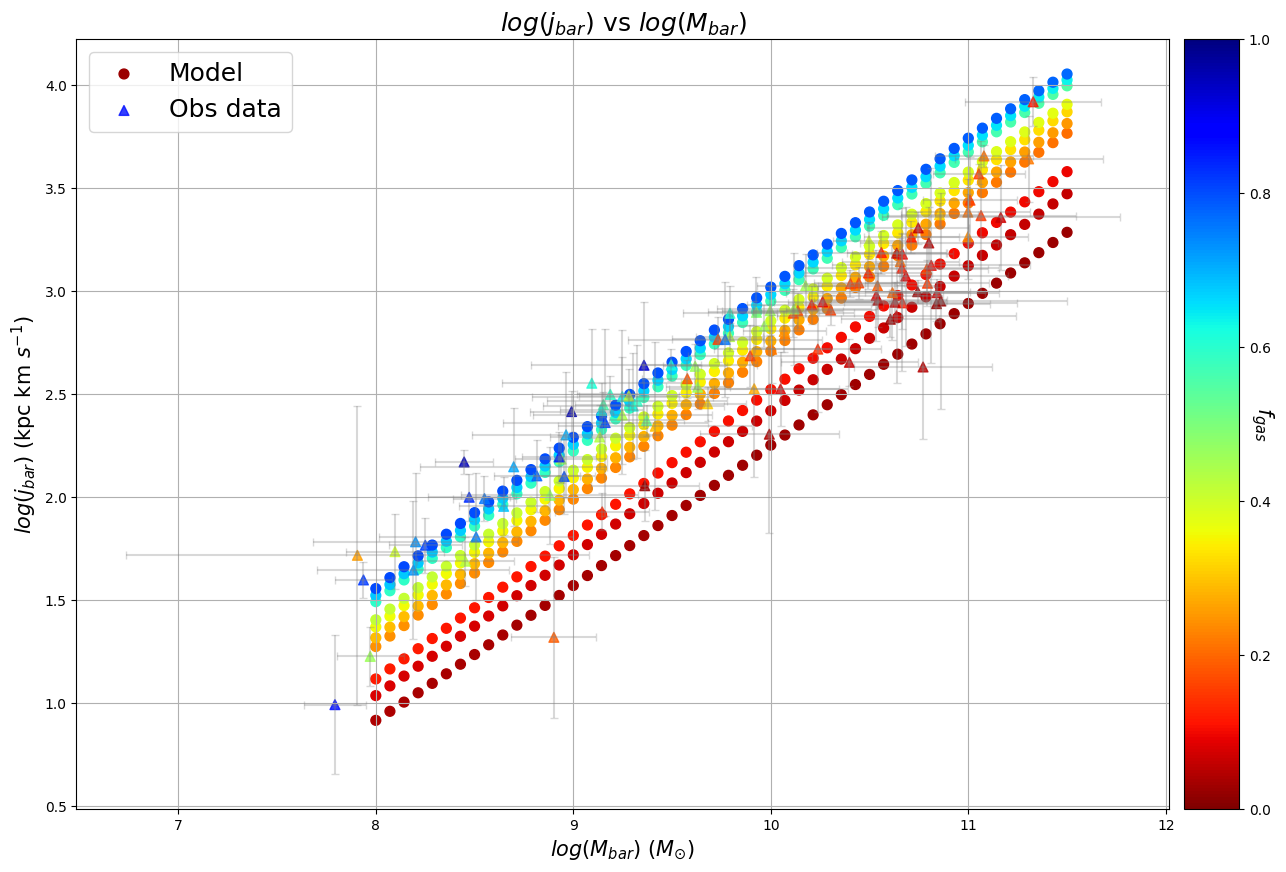

In [3]:
f_gas_array_10_50 = np.loadtxt('data3/final_f_gas.txt')
j_bar_array_10_50 = np.loadtxt('data3/final_j_bar.txt')
log_M_bar_array = np.linspace(8,11.5,50)
t_acc_array = np.array([1,2,3,10,25,-25,-10,-3,-2,-1])

log_f_gas_array_10_50 = np.log10(f_gas_array_10_50)
log_j_bar_array_10_50 = np.log10(j_bar_array_10_50)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_10_50, f_gas_array_10_50):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=50)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/log j_bar vs log_M_bar with Pavel (50 masses).png')

In [33]:
f_gas_array_10_50

array([[0.04035425, 0.07972865, 0.12054781, 0.24468333, 0.29182454,
        0.36092654, 0.4143502 , 0.59419192, 0.67923097, 0.80356608],
       [0.03958821, 0.0788146 , 0.11952907, 0.24356046, 0.29071721,
        0.35987532, 0.41336076, 0.59345605, 0.67861642, 0.80314075],
       [0.03890361, 0.07799899, 0.11862001, 0.24254808, 0.28971214,
        0.35890969, 0.41244196, 0.59274358, 0.67801154, 0.8027174 ],
       [0.03828621, 0.07726462, 0.11780138, 0.24162662, 0.28879115,
        0.35801427, 0.411581  , 0.59205004, 0.67741435, 0.80229549],
       [0.03772429, 0.07659715, 0.11705714, 0.24077974, 0.28793903,
        0.35717628, 0.41076728, 0.5913718 , 0.6768233 , 0.8018746 ],
       [0.03720819, 0.07598475, 0.11637397, 0.23999384, 0.28714319,
        0.35638515, 0.40999206, 0.59070597, 0.67623717, 0.80145443],
       [0.03673003, 0.07541767, 0.11574088, 0.23925775, 0.28639327,
        0.35563223, 0.40924822, 0.59005025, 0.67565503, 0.80103476],
       [0.03628336, 0.07488792, 0.1151488

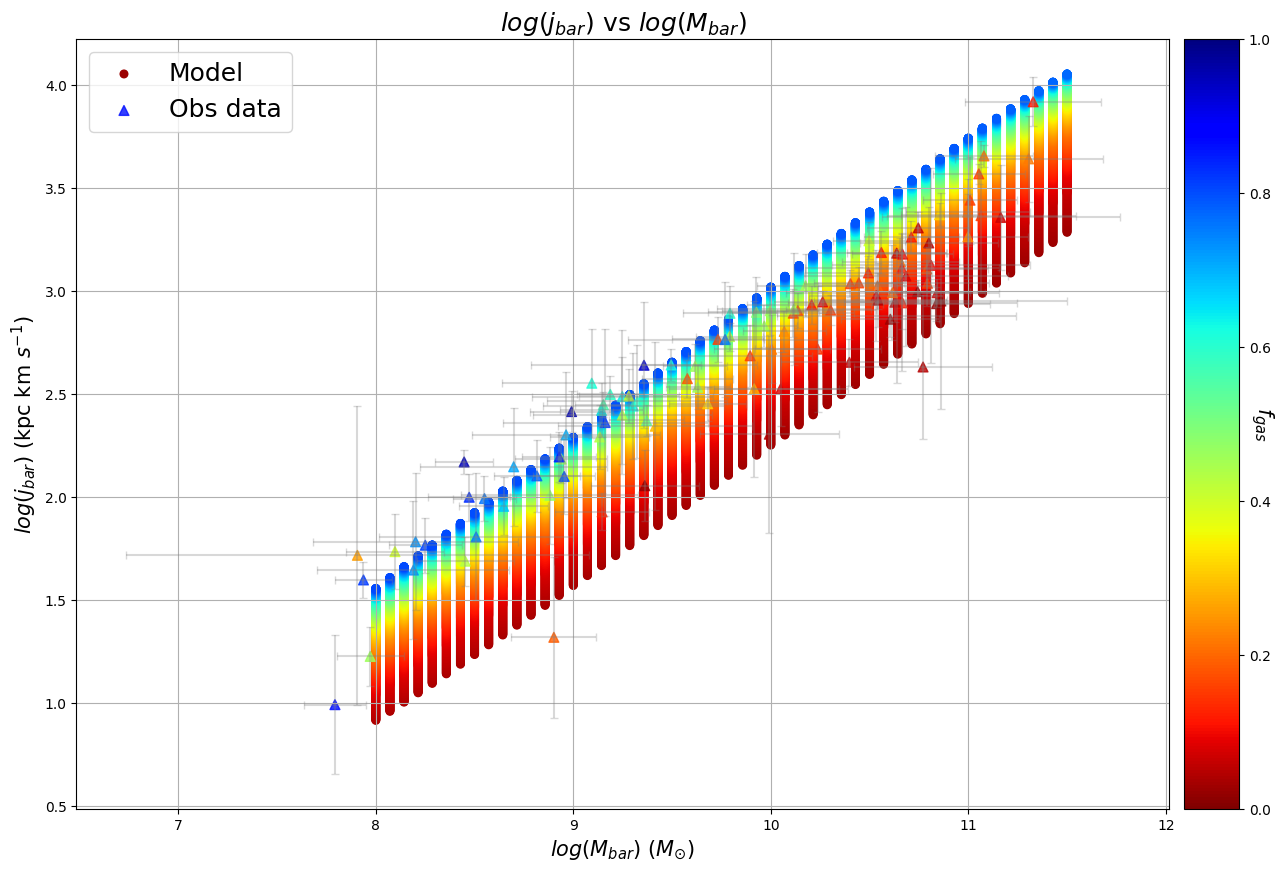

In [4]:
cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe = divider.append_axes("right", size="5%", pad=0.15)

n=1000
interp_f_gas_array_10_50 = np.zeros((len(log_M_bar_array),n))
for i,Mbar in enumerate(log_M_bar_array):
    interp_f_gas_array_10_50[i] = np.linspace(f_gas_array_10_50[i].min(),f_gas_array_10_50[i].max(),n)
    
interp_j_bar_array_10_50 = np.zeros((len(log_M_bar_array),n))
for i,Mbar in enumerate(log_M_bar_array):
    ipl_10_50 = spl.InterpolatedUnivariateSpline(f_gas_array_10_50[i], log_j_bar_array_10_50[i], k=1)
    interp_j_bar_array_10_50[i] = ipl_10_50(interp_f_gas_array_10_50[i])

for x, y, z in zip(log_M_bar_array, interp_j_bar_array_10_50, interp_f_gas_array_10_50):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=30)
gg.set_label("Model")
cbar = fig.colorbar(gg, cax=colbarframe)
cbar.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs4/log j_bar vs log_M_bar with Pavel.png')

# Interpolator

In [5]:
def modelled_j_bar2(f_gas_array, j_bar_array, f_gas_value, kind=1):
    """The function takes as input the arrays for f_gas and j_bar (possibly already interpolated), 
    together with a wanted value of f_gas for which to slice out the 1D array. Inputs:
    - f_gas_array = interpolated 2D array of f_gas
    - j_bar_array = interpolated 2D array of j_bar
    - f_gas_value = value of f_gas for which to slice the f_gas/j_bar arrays
    - kind = Inerpolation type (default is 1 - linear)
    
    The function does the following
    - Creates a list 'index_array', which literally has the indexes of constant f_gas_value chosen as elements.
    - Then, it iteratively takes from the j_bar_array the values corresponding to the indexes from index_array
    - Finally it interpolates the indexed j_bar_array through the M_bar_array, to get a plottable linear function.
    """
    indexed_j_array = []
    index_array = []
    true_list = []
    
    for i in range(len(log_M_bar_array)):
        if f_gas_value>np.min(f_gas_array[i]) and f_gas_value<np.max(f_gas_array[i]):
            index_array.append(np.argwhere(f_gas_array[i] == min(f_gas_array[i], key=lambda x:abs(x-f_gas_value))))
            true_list.append(1)
        else:
            index_array.append(0)
            true_list.append(0)
    
    j = 0
    while (j<50):
        if (true_list[j]==1):
            indexed_j_array.append(j_bar_array[j][index_array[j]])
        j += 1
    
    if len(indexed_j_array)>kind:
        index = np.argwhere(np.array(true_list) == 1)
        indexed_M_array = log_M_bar_array[index]
        indexed_M_array_lin = np.linspace(indexed_M_array[0], indexed_M_array[-1], 1000)
        interpolation = spl.InterpolatedUnivariateSpline(indexed_M_array.reshape(len(indexed_M_array),), indexed_j_array, k=kind)
        interpolated_j_array = interpolation(indexed_M_array_lin).reshape(len(indexed_M_array_lin),)
    else:
        indexed_M_array_lin = []
        interpolated_j_array = []
    
    return indexed_M_array_lin, interpolated_j_array

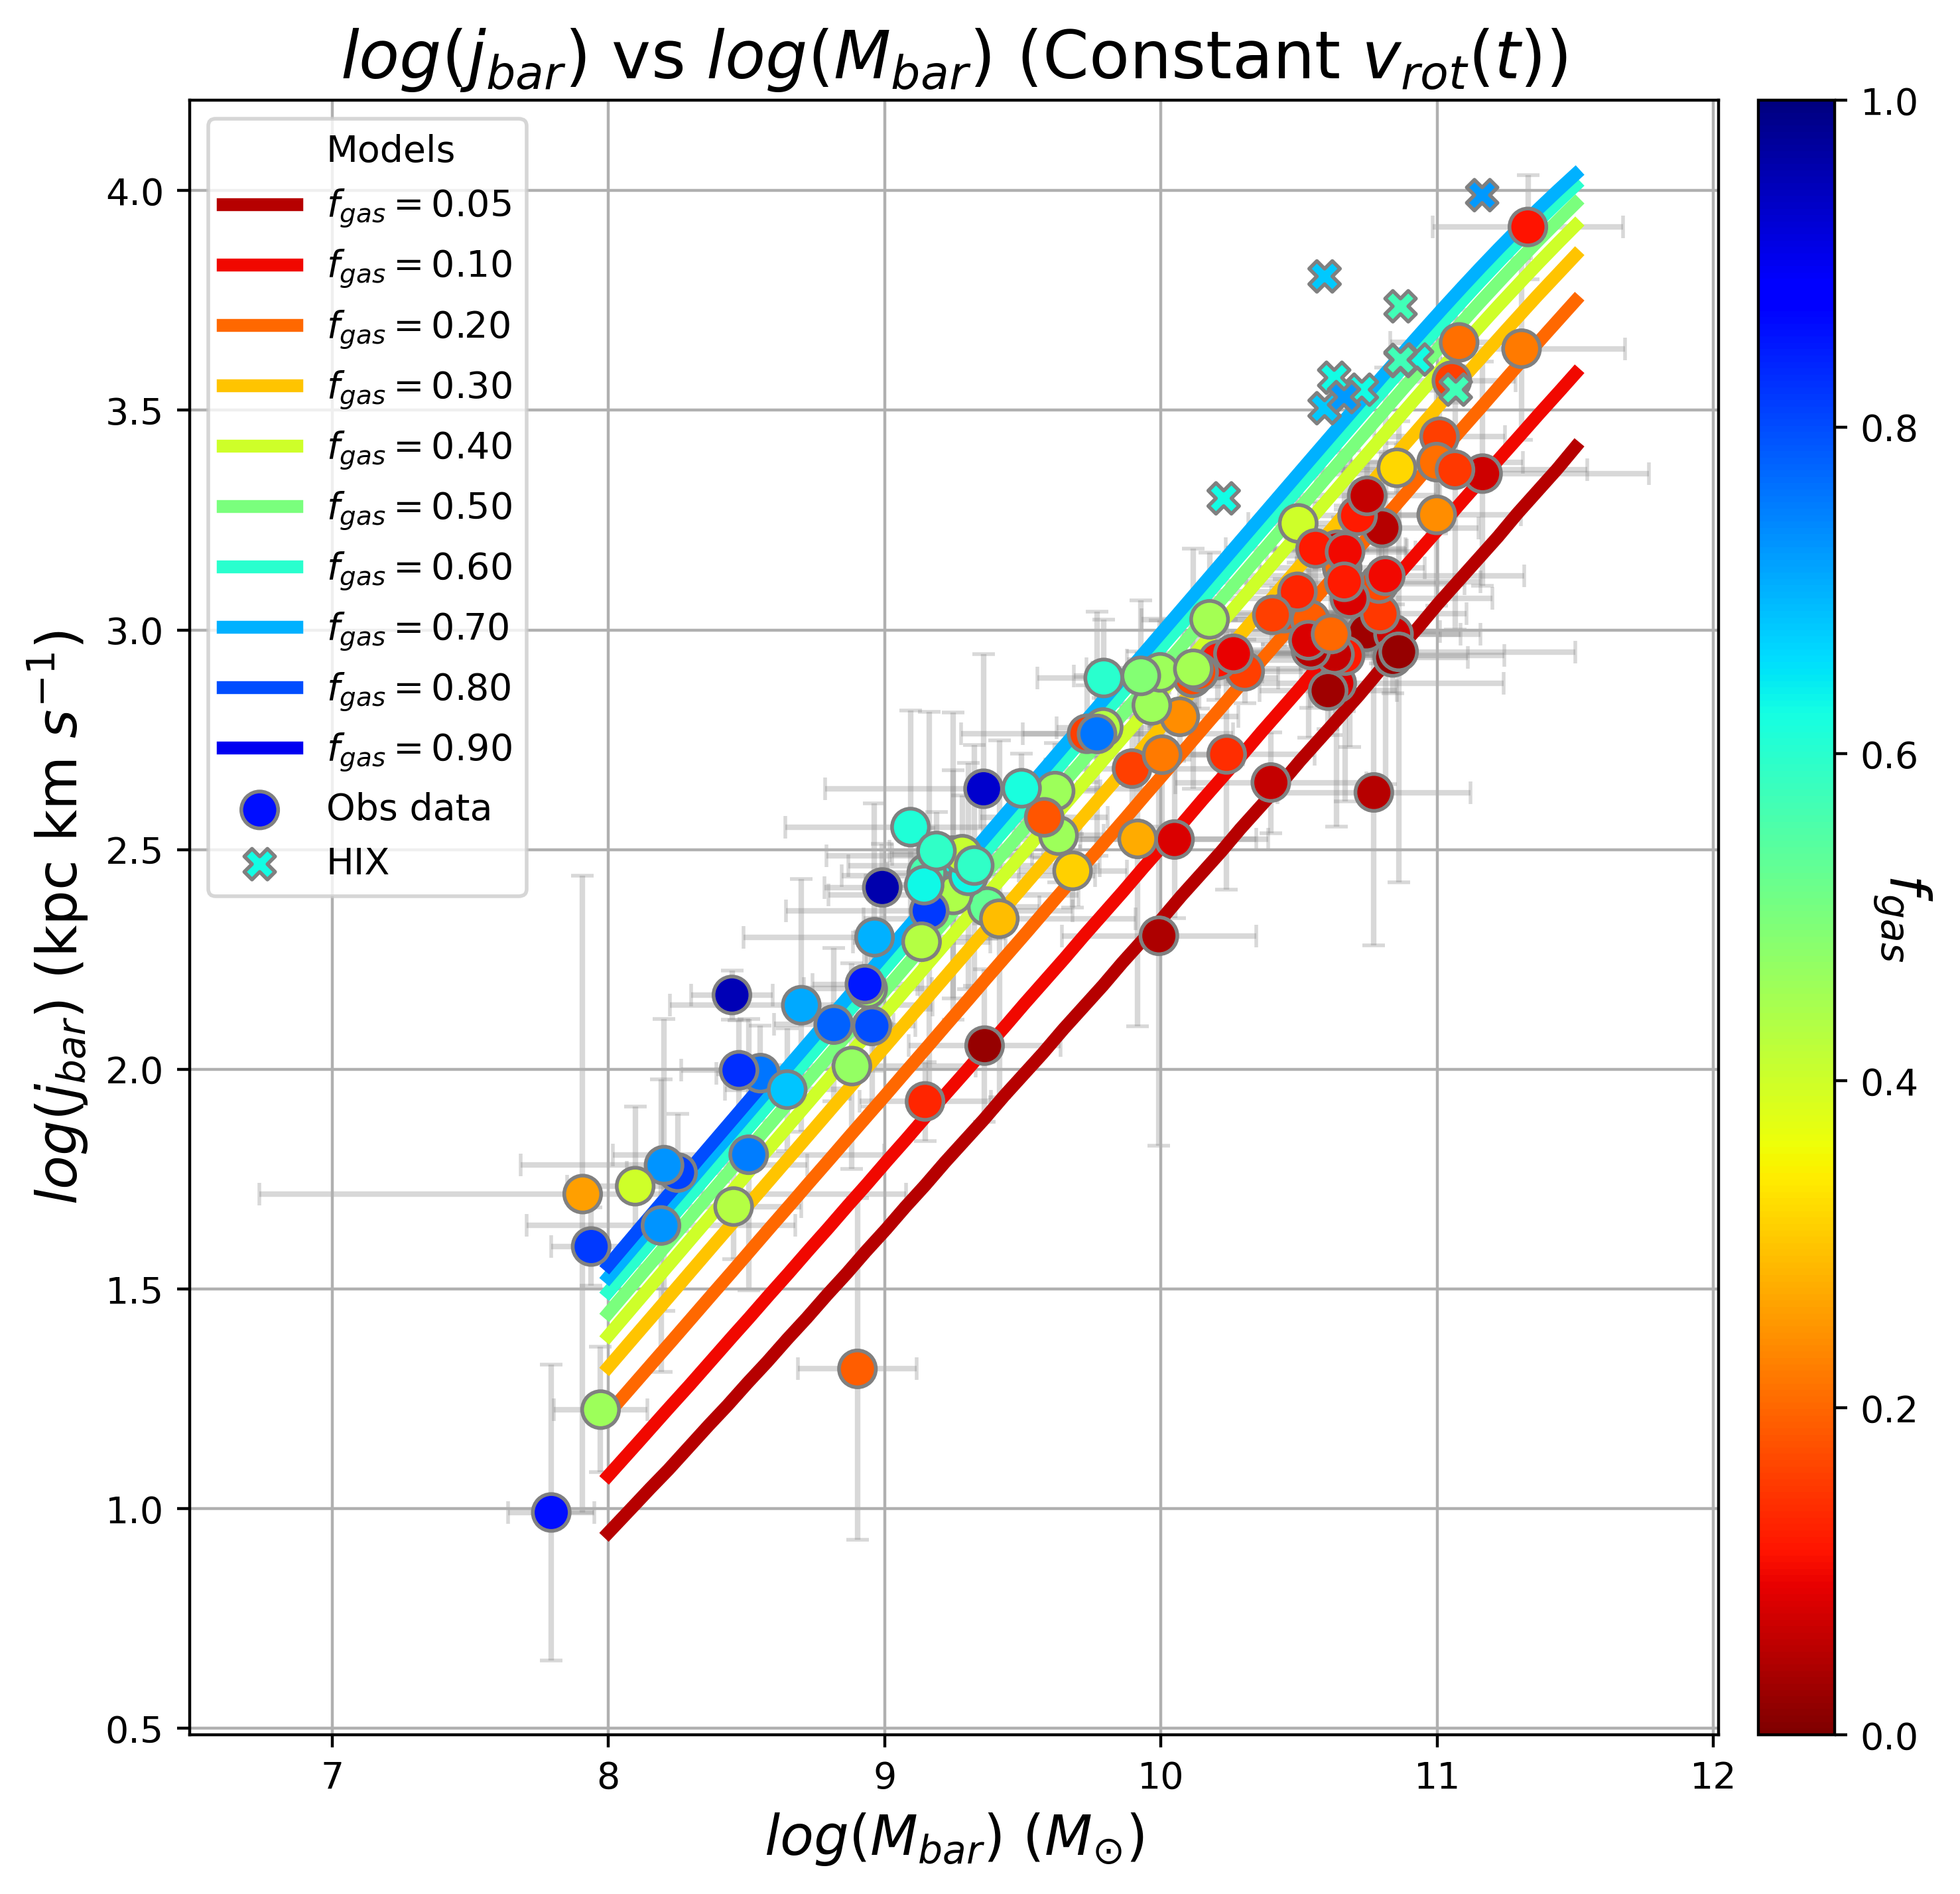

In [13]:
cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(8,8), dpi=400, facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe = divider.append_axes("right", size="5%", pad=0.15)

frame.plot([], [], ' ', label="Models")

f_gas_values = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cmap(f_gas_values)
for i,f_gas_value in enumerate(f_gas_values):
    indexed_M_array_lin, indexed_j_array = modelled_j_bar2(interp_f_gas_array_10_50, interp_j_bar_array_10_50, f_gas_value)
    ax1 = frame.plot(indexed_M_array_lin, indexed_j_array, label=r"$f_{gas} = $"+f"{f_gas_value:.2f}", color=colors[i], lw=3.5, zorder=2)

#frame.plot(log_M_bar_array, np.log10(j_maxer(10**log_M_bar_array)), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
ax2 = frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="o", facecolors=cmap(BARY['fgas']), edgecolors="grey", s=100, zorder=3)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3, zorder=0)
cbar = fig.colorbar(ax2, cax=colbarframe)
cbar.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

ax3 = frame.scatter(np.log10(10**HIX_logMstar + 10**HIX_logMHI), np.log10(HIX_jbar), label="HIX", marker="X", facecolors=cmap(10**HIX_logMHI/(10**HIX_logMstar + 10**HIX_logMHI)), edgecolors="grey", s=70, zorder=3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ (Constant $v_{rot}(t)$)", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend()
frame.grid(zorder=1)
show()
fig.savefig('graphs4/log j_bar vs log_M_bar with Pavel (interpolated).png')